In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lib.core import *

In [4]:
pd.DataFrame(check_dep_versions())

Python       tqdm  numpy pandas   scipy statsmodels matplotlib  \
installed    3.12.12     4.67.1  2.3.5  2.3.3  1.16.3      0.14.5     3.10.8   
expected        3.12       None  2.3.5  2.3.3  1.16.3      0.14.5     3.10.8   
op                ==       None     >=     >=      >=          >=         >=   
status     installed  installed     ok     ok      ok          ok         ok   

          seaborn datashader ultraplot scikit-learn  cooler cooltools  \
installed  0.13.2     0.18.2    1.66.0        1.7.2  0.10.4     0.7.1   
expected   0.13.2     0.18.2    1.66.0         None  0.10.4     0.7.1   
op             >=         >=        >=         None      >=        >=   
status         ok         ok        ok    installed      ok        ok   

          bioframe fontanka  pybbi  
installed    0.8.0      0.2  0.4.2  
expected     0.8.0      0.2  0.4.2  
op              >=       >=     >=  
status          ok       ok     ok

In [5]:
from lib.read_data_basic import *

In [6]:
from lib.read_data_hic import *

[10:47:48] lib:INFO: Loading fountain BEDs for sources: WT, Wild-Type_2.75, TR, Wild-Type_11, Wild-Type_25
[10:47:48] lib:INFO: Loading 200 Kb snippet dct_stacks_hic for sources: WT, PS, SN, NP, TR, MZsox19b_5.3, MZnanog_5.3, MZspg_5.3, Wild-Type_2.75, Wild-Type_5.3, Wild-Type_11, Wild-Type_25, Wike2021_WT_ZF_Embryos_4hpf_FLAV, Wike2021_WT_ZF_Embryos_4hpf_SGC, Wike2021_WT_ZF_Embryos_4hpf_DMSO, sperm
[10:49:09] lib:INFO: Loading WT average fountain template and computing similarity scores
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134528/134528 [00:12<00:00, 11013.36it/s]


In [7]:
from lib.read_data_epigenetics import *

[10:52:23] lib:INFO: Collecting epigenetic stacks (default flank)
[10:52:23] lib:INFO: Collecting epigenetic background bedgraphs
[10:52:39] lib:INFO: Loaded 246 background bedgraphs
[10:53:32] lib:INFO: Loaded 246 stacks (default flank)
[10:53:32] lib:INFO: Building 10 Kb bin annotation table
[10:53:32] lib:INFO: Merging 246 bedgraph tracks into bin annotations
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:20<00:00, 11.97it/s]
[10:53:53] lib:INFO: Loading replication initiation zones (Supplemental Dataset 4)
[10:53:53] lib:INFO: Loading origin-to-fountain distance tables
[10:53:53] lib:INFO: Loading ATAC-seq peaks around summits (WT)


In [8]:
# # Set up saving mode
do_save = True
output_folder = "./results_2025-12-03_AxG"
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

# + Enrichment of chromatin states (Fig 4G,H; Fig 2C)

In [191]:
section_start()

✅ Section started


## Load task-specific data

## Plot and save

In [9]:
sources_fountains = ["WT"]

In [10]:
# Calculate enrichments for the fountains in each condition:
dict_enrichments = {}

for source_fountains in sources_fountains:

    # Read fountains:
    df_fount = dict_fountains[source_fountains]
    idx_selected_fount_true = df_fount.index

    df_res = []
    for s in tqdm.tqdm(bins_states.columns[3:]):
        stage = "_".join(s.split("_")[-1:])
        state = "_".join(s.split("_")[:2])

        # Calculate coverage by the target state:
        v_observed = bins_states.loc[idx_selected_fount_true, s]

        # Calculate coverage by all possible states (in other words, open chromatin):
        v_ctrl = bins_states.loc[idx_selected_fount_true, f"totalcov_{stage}"]

        # Enrichment of the chromatin state per 10 Kb-bin:
        v_enrichments = v_observed / v_ctrl

        df_res.append(
            [
                s,
                stage,
                state,
                "observed",
                np.nanmean(v_enrichments),
                np.nanstd(v_enrichments),
            ]
        )

        # Calculate expected by chance (random assignment of fountains to bins:
        for i in range(1000):
            idx_selected_fount_random = np.random.randint(
                0, len(bins_states), len(df_fount)
            )

            v_observed_random = bins_states.loc[idx_selected_fount_random, s]
            v_ctrl_random = bins_states.loc[
                idx_selected_fount_random, f"totalcov_{stage}"
            ]
            v_enrichments_random = v_observed_random / v_ctrl_random

            df_res.append(
                [
                    s,
                    stage,
                    state,
                    "expected",
                    np.nanmean(v_enrichments_random),
                    np.nanstd(v_enrichments_random),
                ]
            )

    df_res = pd.DataFrame(
        df_res, columns=["label", "stage", "state", "type", "mean", "std"]
    )

    dict_enrichments[source_fountains] = df_res.copy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.19it/s]


In [11]:
# Calculate enrichments for the differential fountains:
dict_enrichments_differential = {}

col_type_fount = "diff_TR_vs_WT"
types_fount = ["down", "same", "up"]

for type_fount in types_fount:

    # Read fountains:
    df_fount = df_fount_differential.query(f"{col_type_fount}=='{type_fount}'")
    idx_selected_fount_true = df_fount.index

    df_res = []
    for s in tqdm.tqdm(bins_states.columns[3:]):
        stage = "_".join(s.split("_")[-1:])
        state = "_".join(s.split("_")[:2])

        # Calculate coverage by the target state:
        v_observed = bins_states.loc[idx_selected_fount_true, s]

        # Calculate coverage by all possible states (in other words, open chromatin):
        v_ctrl = bins_states.loc[idx_selected_fount_true, f"totalcov_{stage}"]

        # Enrichment of the chromatin state per 10 Kb-bin:
        v_enrichments = v_observed / v_ctrl

        df_res.append(
            [
                s,
                stage,
                state,
                "observed",
                np.nanmean(v_enrichments),
                np.nanstd(v_enrichments),
            ]
        )

        # Calculate expected by chance (random assignment of fountains to bins:
        for i in range(1000):
            idx_selected_fount_random = np.random.randint(
                0, len(bins_states), len(df_fount)
            )

            v_observed_random = bins_states.loc[idx_selected_fount_random, s]
            v_ctrl_random = bins_states.loc[
                idx_selected_fount_random, f"totalcov_{stage}"
            ]
            v_enrichments_random = v_observed_random / v_ctrl_random

            df_res.append(
                [
                    s,
                    stage,
                    state,
                    "expected",
                    np.nanmean(v_enrichments_random),
                    np.nanstd(v_enrichments_random),
                ]
            )

    df_res = pd.DataFrame(
        df_res, columns=["label", "stage", "state", "type", "mean", "std"]
    )

    dict_enrichments_differential[type_fount] = df_res.copy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.32it/s]


In [12]:
def plot_violin_obs_exp(col_value, col_category, col_type, **kwargs):
    """Plot signature violin plots of expected overlaid with the observed signal as a scatter dot on top."""
    mask_obs = col_type == "observed"
    mask_exp = col_type == "expected"

    if not "color" in kwargs and not "palette" in kwargs:
        kwargs["palette"] = "Set1"

    sns.stripplot(x=col_value[mask_obs], y=col_category[mask_obs], **kwargs)

    if "color" in kwargs.keys():
        del kwargs["color"]
    if "palette" in kwargs.keys():
        del kwargs["palette"]

    sns.violinplot(
        x=col_value[mask_exp],
        y=col_category[mask_exp],
        hue=col_type[mask_exp],
        palette="Greys",
        linewidth=1.2,
        **kwargs
    )

In [13]:
order_states = [
    "1_TssA1",
    "2_TssA2",
    "3_TssFlank1",
    "4_TssFlank2",
    "5_EnhA1",
    "6_EnhFlank",
    "7_EnhWk1",
    "8_Pois",
    "9_ReprPC",
    "10_Quies",
]
labels_states = [
    "TSS A1",
    "TSS A2",
    "TSS Flank 1",
    "TSS Flank 2",
    "Enhancer A1",
    "Enhancer Flank",
    "Enhancer Weak 1",
    "Poised",
    "Repressed PC",
    "Quiescent",
]
colors_states = [
    "#A7CEE3",
    "#2F85BB",
    "#4CAD54",
    "#B4D48B",
    "#E7373F",
    "#F5ADAD",
    "#F08420",
    "#76539C",
    "#D0BCDA",
    "#AAABAC",
]

### + All fountains and chromatin states (Fig. 2C)

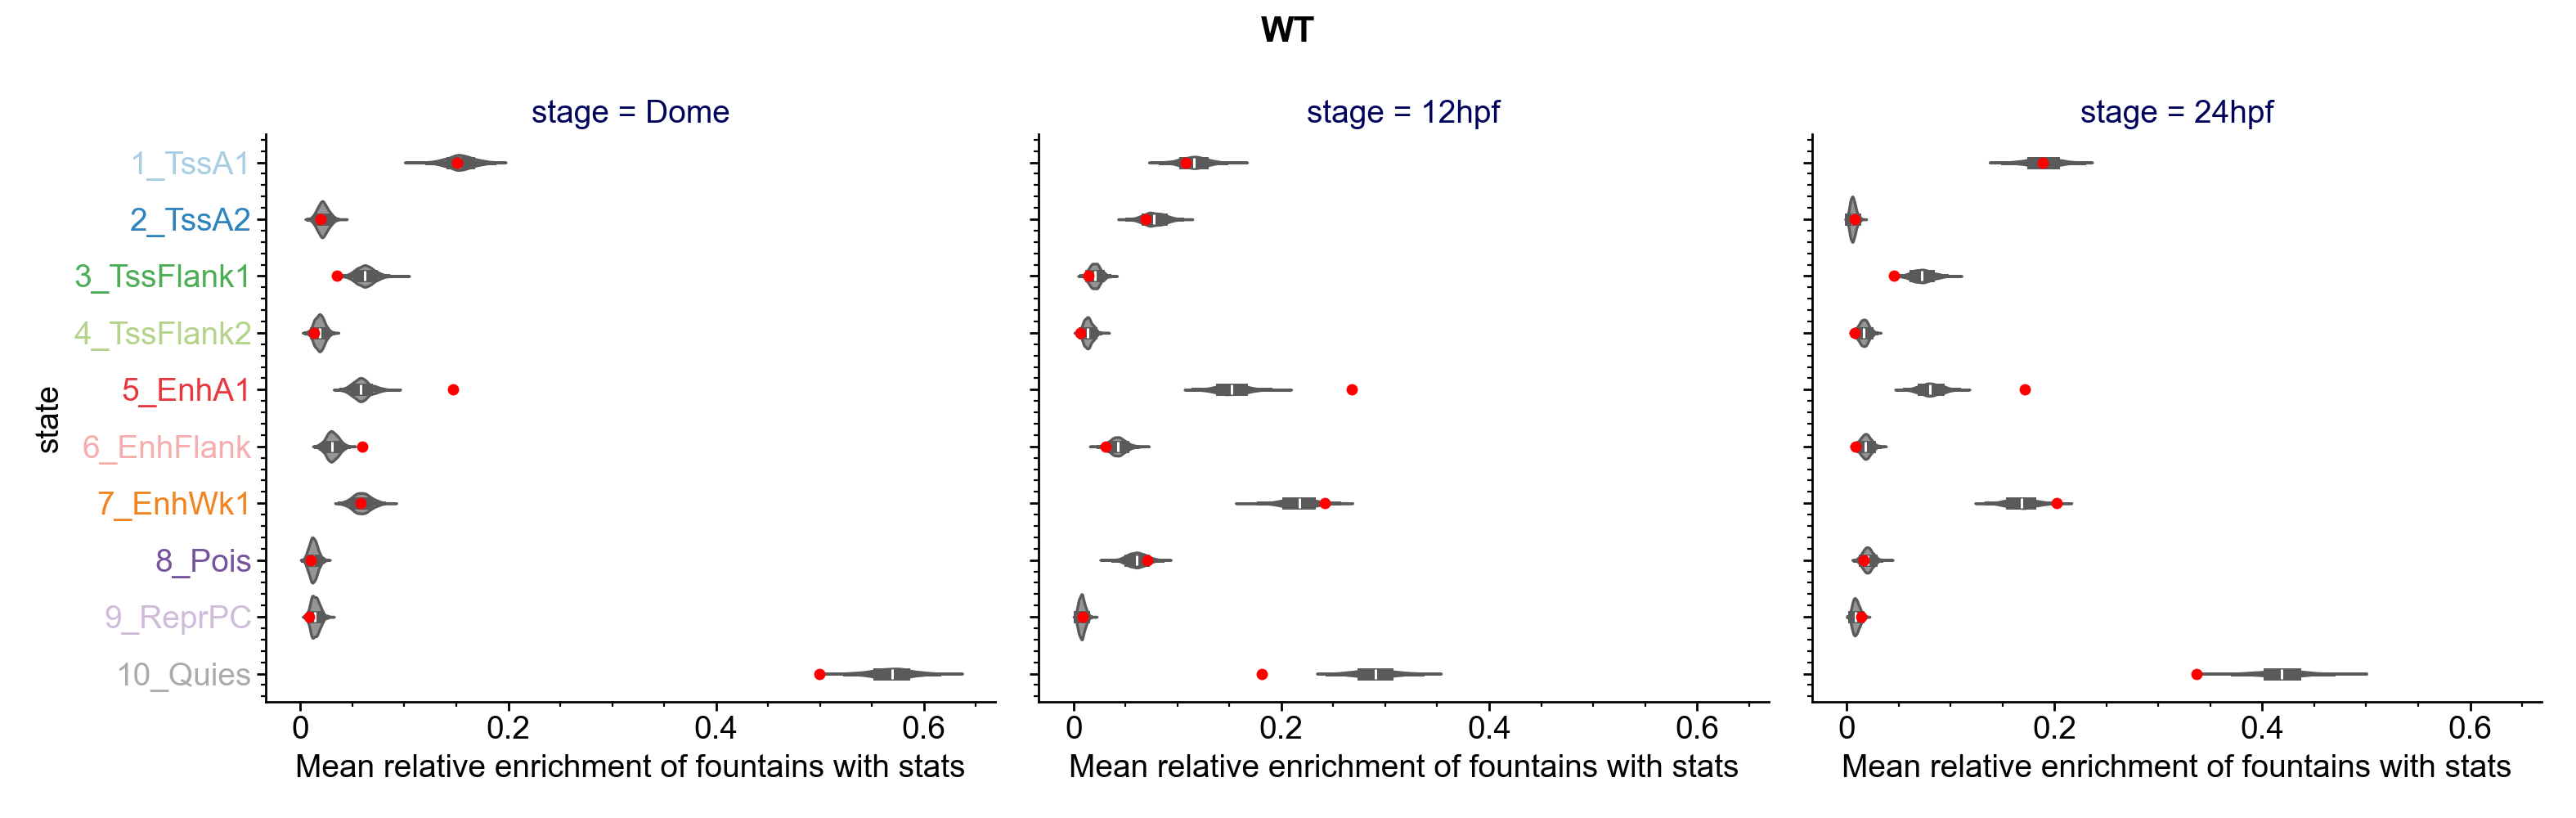

In [14]:
sources_fountains = ["WT"]

for source_fountains in sources_fountains:

    df_res = dict_enrichments[source_fountains].query(f"state in {order_states}")

    g = sns.FacetGrid(df_res, col="stage", height=5, aspect=1.05)
    g.map(
        plot_violin_obs_exp,
        "mean",
        "state",
        "type",
        orient="h",
        color="red",
        order=order_states,
    )

    # Set OY labels colors:
    for idx_selected, ax in g.axes_dict.items():
        ax.set_xlabel("Mean relative enrichment of fountains with stats")
        for i, label in enumerate(ax.get_yticklabels()):
            label.set_color(colors_states[i])

    g.figure.suptitle(source_fountains)
    g.figure.tight_layout()

    if do_save:
        prefix = f"{output_folder}/Fig2C.state-enrichment.WT"
        g.figure.savefig(f"{prefix}.pdf")
        g.figure.savefig(f"{prefix}.png")

In [15]:
# Store the table:
if do_save:
    for source_fountains in sources_fountains:
        df_res = dict_enrichments[source_fountains].query(f"state in {order_states}")

        prefix = f"{output_folder}/Fig2C.state-enrichment.WT"
        data_towrite = df_res.groupby(["stage", "state", "type"]).describe()["mean"]

        data_towrite.to_csv(f"{prefix}.source.csv", sep="\t")

### + Differential fountains in TR mutant (Fig. 4GH)

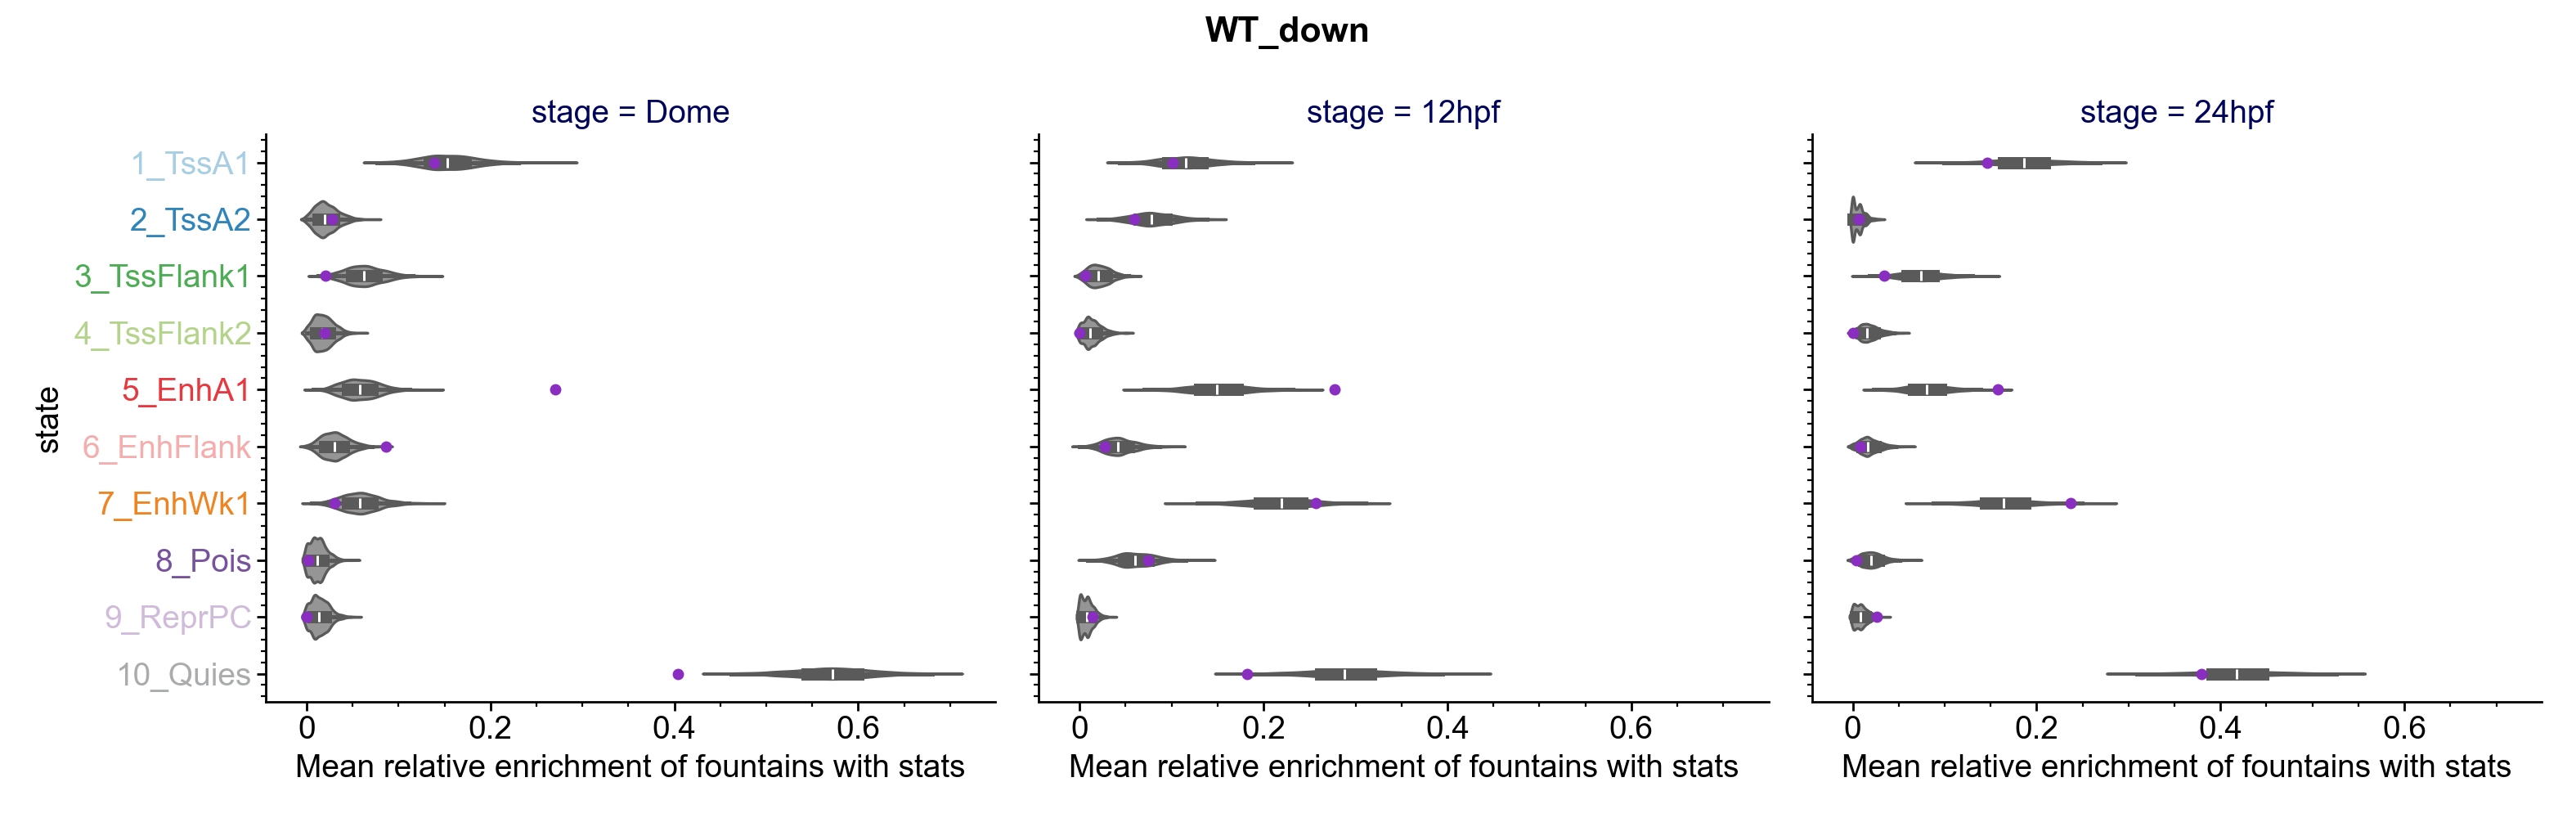

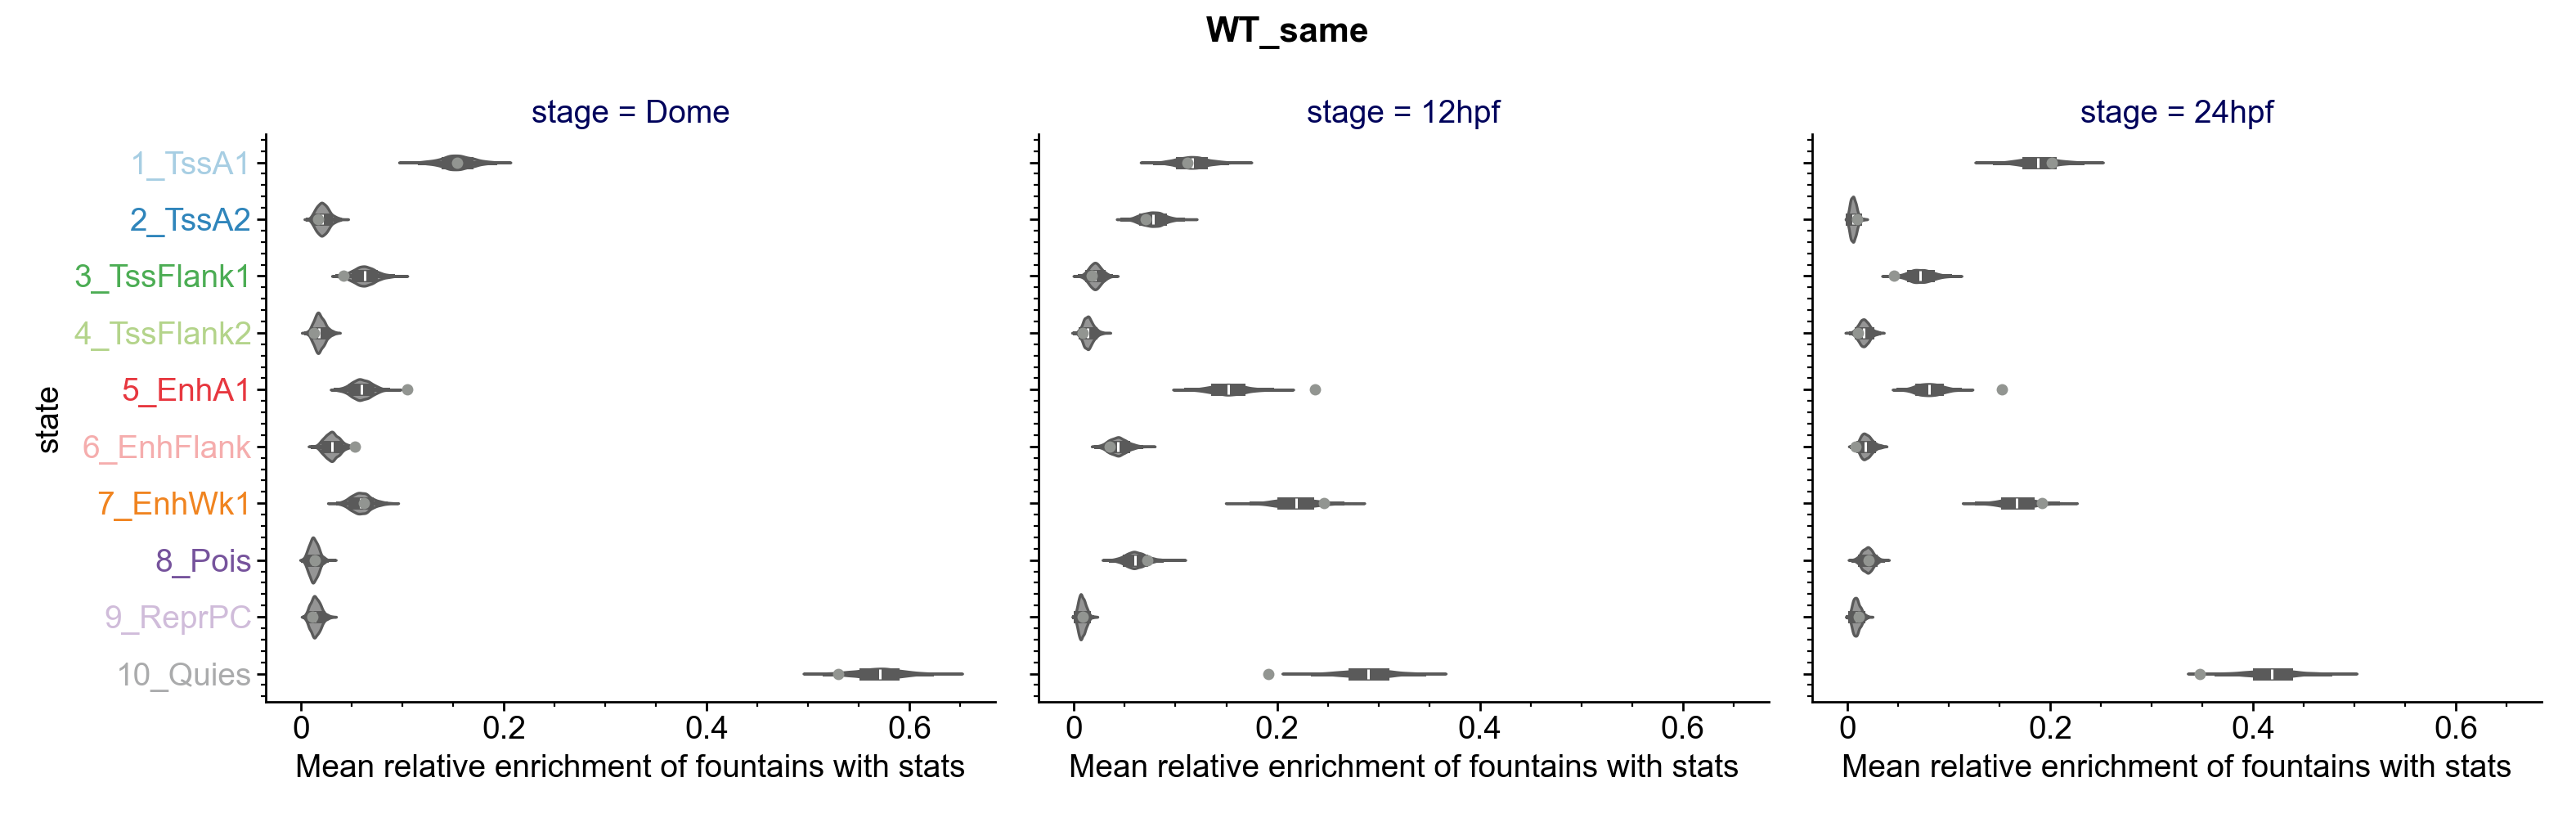

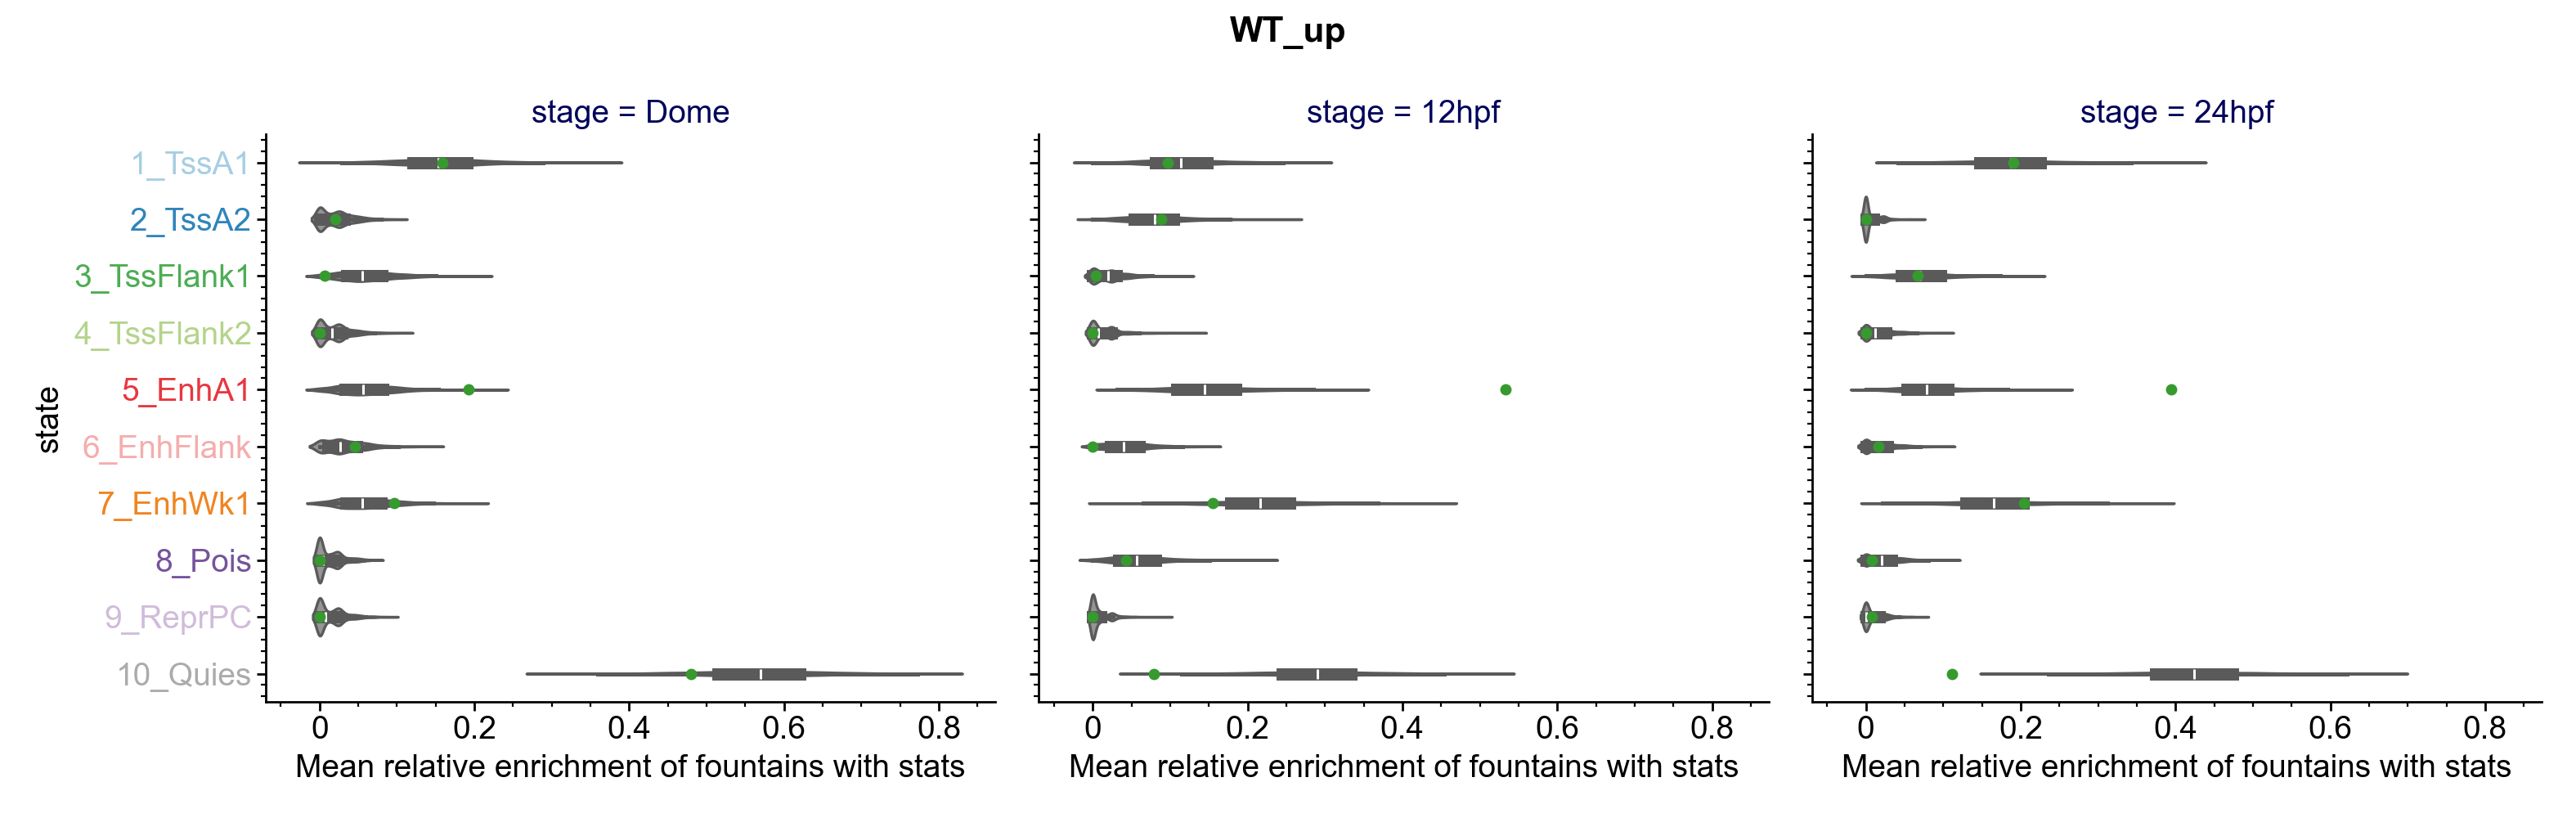

In [16]:
col_type_fount = "diff_TR_vs_WT"
types_fount = ["down", "same", "up"]
colors_types = {
    "down": color_fount_down,
    "same": color_fount_same,
    "up": color_fount_up,
}

for type_fount in types_fount:

    df_res = dict_enrichments_differential[type_fount].query(f"state in {order_states}")

    g = sns.FacetGrid(df_res, col="stage", height=5, aspect=1.05)
    g.map(
        plot_violin_obs_exp,
        "mean",
        "state",
        "type",
        orient="h",
        order=order_states,
        color=colors_types[type_fount],
    )

    # Set OY labels colors:
    for idx_selected, ax in g.axes_dict.items():
        ax.set_xlabel("Mean relative enrichment of fountains with stats")
        for i, label in enumerate(ax.get_yticklabels()):
            label.set_color(colors_states[i])

    g.figure.suptitle(source_fountains + "_" + type_fount)
    g.figure.tight_layout()

    if do_save:
        prefix = f"{output_folder}/Fig4GH.state-enrichment.TR-WT-{type_fount}"
        g.figure.savefig(f"{prefix}.pdf")
        g.figure.savefig(f"{prefix}.png")

In [17]:
# Store the table:
if do_save:
    for type_fount in types_fount:
        df_res = dict_enrichments_differential[type_fount].query(
            f"state in {order_states}"
        )

        prefix = f"{output_folder}/Fig4GH.state-enrichment.TR-WT-{type_fount}"
        data_towrite = df_res.groupby(["stage", "state", "type"]).describe()["mean"]

        data_towrite.to_csv(f"{prefix}.source.csv", sep="\t")

In [18]:
section_flush()

✅ Section cleaned


# + Epigenetics pileups

In [19]:
section_start()

✅ Section started


### Fountains vs boundaries

#### + Pileup (Fig. 2A-top)

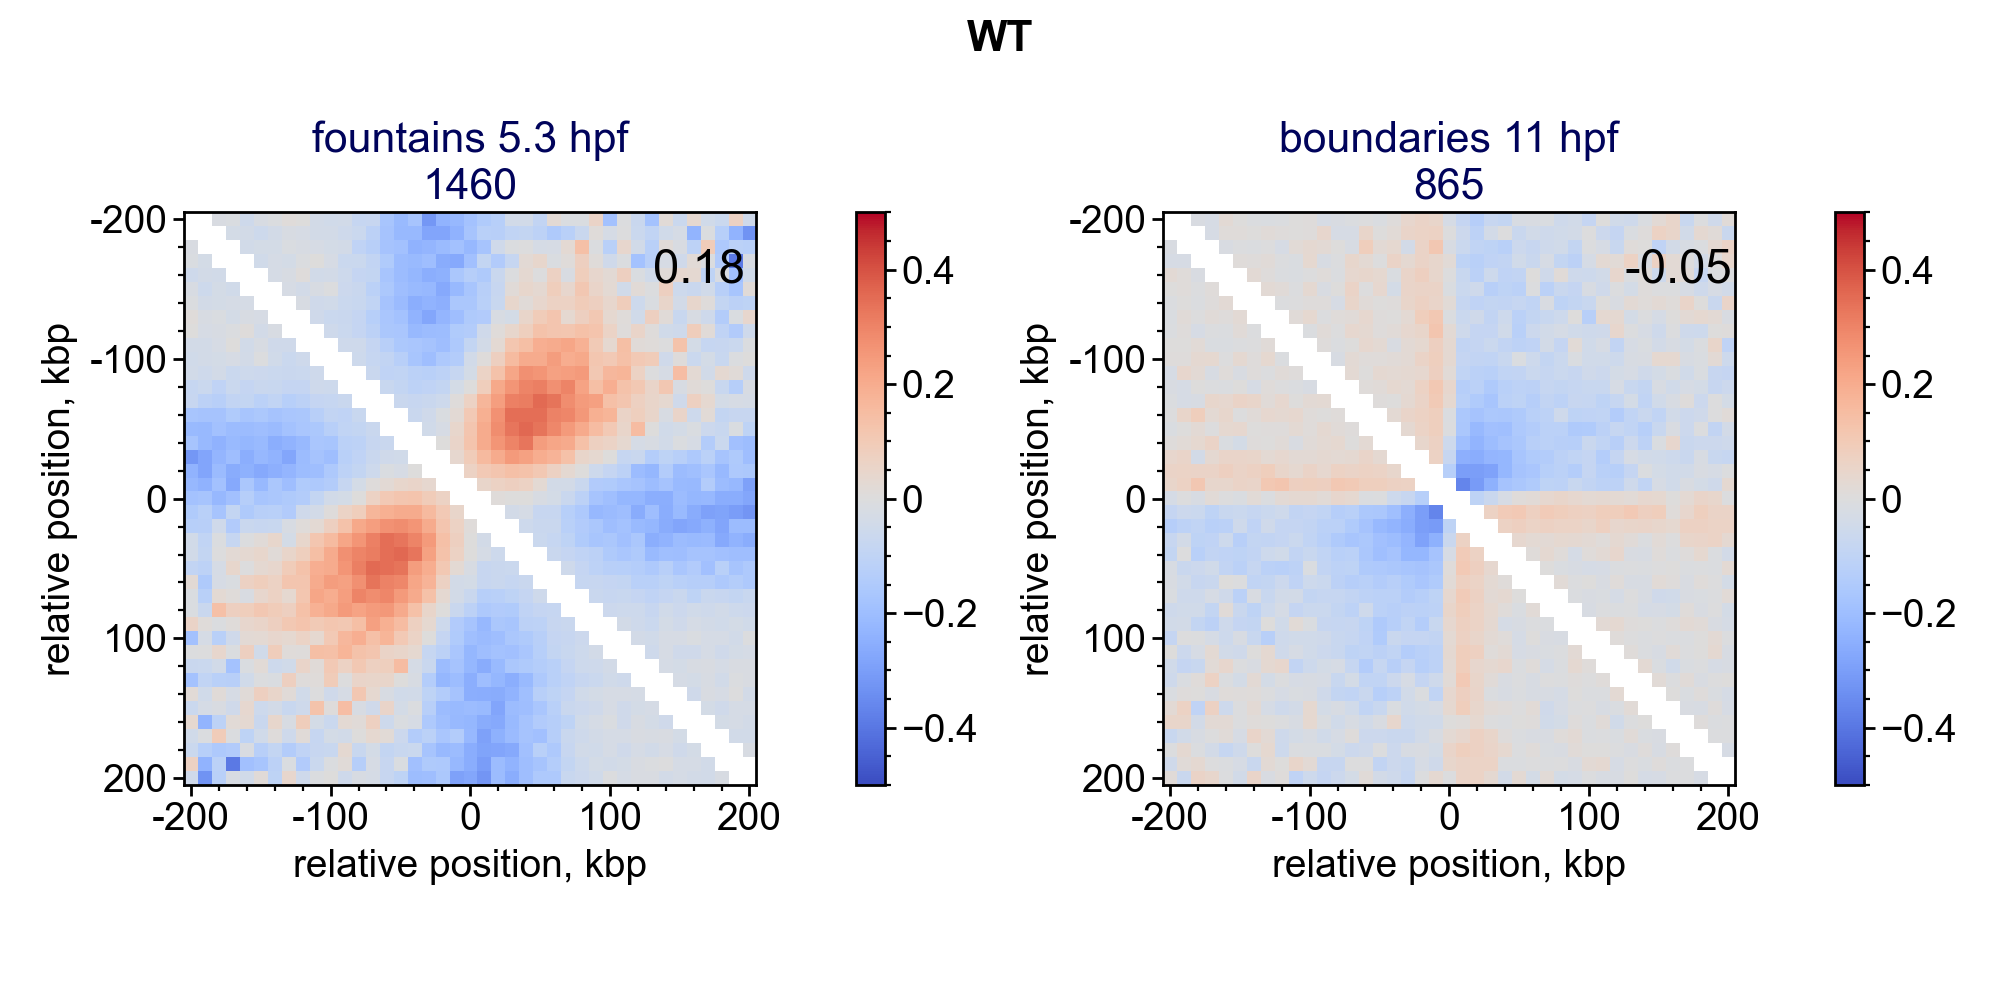

In [20]:
# Save the Hi-C pileups
df_boundaries = bins.loc[bins_boundaries_robust, :]

titles = ["fountains 5.3 hpf", "boundaries 11 hpf"]
idxs = [df_fount_differential.index, df_boundaries.index]

for source_fountains in ["WT"]:

    stacks_list = dct_stacks_hic[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=2,
        flank=200_000,
        resolution=10_000,
        figsize=(10, 5),
        vmin=-0.5,
        vmax=0.5,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df_fountain_strength[source_fountains],
        add_counts=True,
    )

    f.suptitle(source_fountains)

if do_save:
    prefix = f"{output_folder}/Fig2A-top.pileups.WT-fount-bound"
    f.savefig(f"{prefix}.pdf")
    f.savefig(f"{prefix}.png")

In [21]:
# Save the Hi-C pileups:
df_boundaries = bins.loc[bins_boundaries_robust, :]

titles = ["fountains 5.3 hpf", "boundaries 11 hpf"]
idxs = [df_fount_differential.index, df_boundaries.index]

for source_fountains in ["WT"]:

    stacks_list = dct_stacks_hic[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        avscore=df_fountain_strength[source_fountains],
        return_source_data=True,
    );

In [22]:
if do_save:
    # Fountains:
    df_tmp = pd.DataFrame(data_pileups[0][2])
    df_tmp.insert(loc=0, column="fountain score", value=data_pileups[0][1])
    df_tmp.insert(loc=0, column="label", value=data_pileups[0][0])

    prefix = f"{output_folder}/Fig2A-top.pileups.WT-fount"
    df_tmp.to_csv(f"{prefix}.source.tsv", sep="\t")

    # Boundaries:
    df_tmp = pd.DataFrame(data_pileups[1][2])
    df_tmp.insert(loc=0, column="fountain score", value=data_pileups[1][1])
    df_tmp.insert(loc=0, column="label", value=data_pileups[1][0])

    prefix = f"{output_folder}/Fig2A-top.pileups.WT-bound"
    df_tmp.to_csv(f"{prefix}.source.tsv", sep="\t")

In [23]:
section_flush()

✅ Section cleaned


#### + General epigenetics (Fig. 2A-bottom)

In [24]:
section_start()

✅ Section started


In [25]:
df_boundaries = bins.loc[bins_boundaries_robust, :]
conds = [
    (df_fount_differential.index, "fountains 5.3 hpf", color_fountains_dome),
    (df_boundaries.index, "boundaries 11 hpf", color_insulation_late),
]

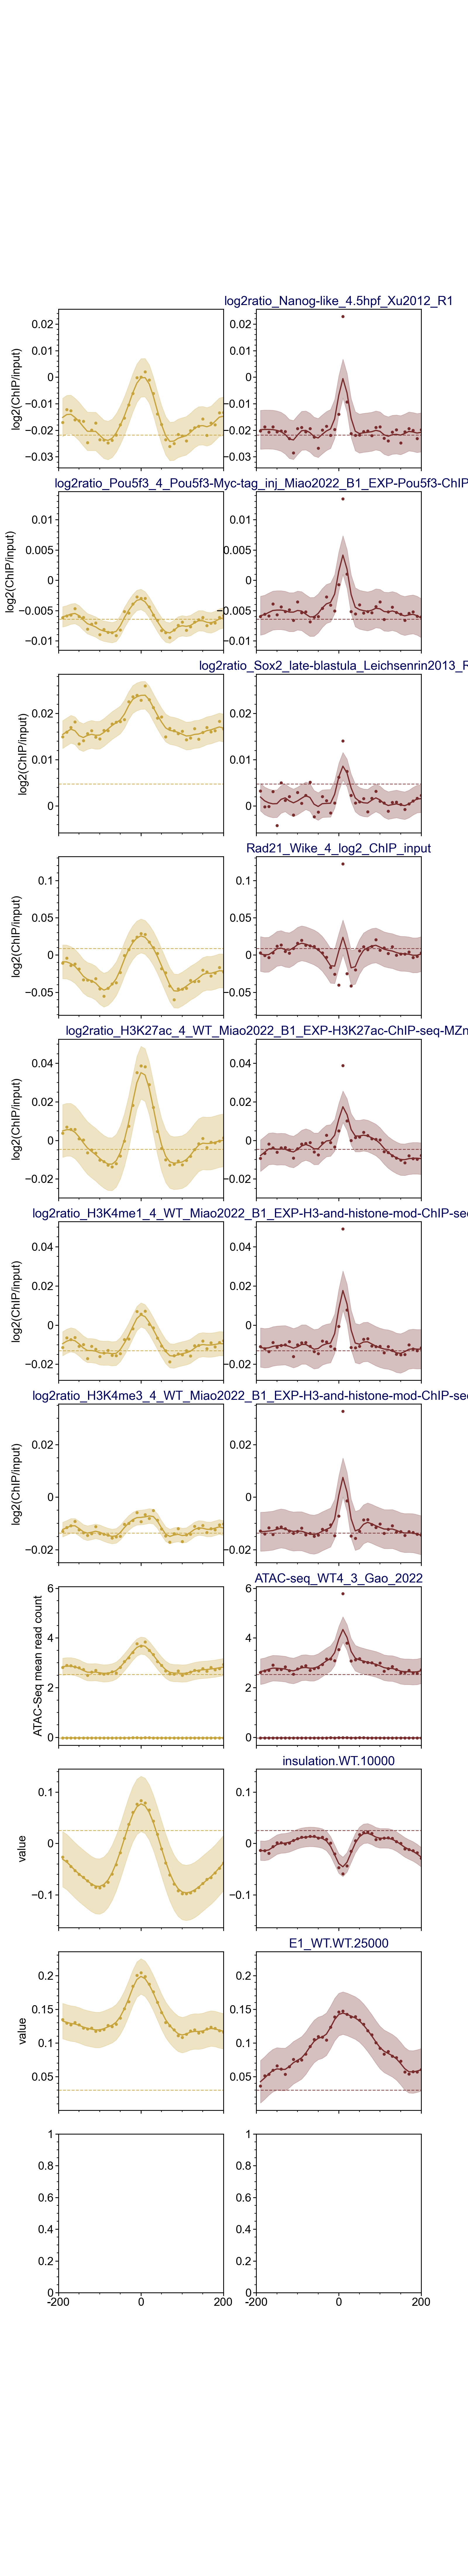

In [26]:
n_tracks_total = 11
n_conditions = 2
figsize = 4

flank = 200_000
ticks_sep = 200_000

f, axes = plt.subplots(
    n_tracks_total,
    n_conditions,
    figsize=[figsize * n_conditions, figsize * n_tracks_total],
    sharex=True,
    gridspec_kw={"hspace": 0.15},
)

# Control figure alignment and ticks:
for i_row in range(n_tracks_total):
    axes[i_row, 0].sharey(*axes[i_row, 1:])

# for i_col in range(1, n_conditions):
#     for i_row in range(n_tracks_total):
#         axes[i_row, i_col].set_yticklabels([])

##########
# Rows for Nanog, Pou and Soc binsding, histone modifications and p300:
##########
ylabel = "log2(ChIP/input)"
i_row_offset = 0
tracks = [
    "log2ratio_Nanog-like_4.5hpf_Xu2012_R1",
    "log2ratio_Pou5f3_4_Pou5f3-Myc-tag_inj_Miao2022_B1_EXP-Pou5f3-ChIP-seq-4h_SRX13823181_R1",
    "log2ratio_Sox2_late-blastula_Leichsenrin2013_R1",
    "Rad21_Wike_4_log2_ChIP_input",
    "log2ratio_H3K27ac_4_WT_Miao2022_B1_EXP-H3K27ac-ChIP-seq-MZnps-4h_SRX13823124_R1",
    "log2ratio_H3K4me1_4_WT_Miao2022_B1_EXP-H3-and-histone-mod-ChIP-seq-MZnps-4h_SRX13823129_R1",
    "log2ratio_H3K4me3_4_WT_Miao2022_B1_EXP-H3-and-histone-mod-ChIP-seq-MZnps-4h_SRX13823130_R1",
    "log2ratio_p300_4_WT_Miao2022_B1_EXP-p300-and-histone-ac-ChIP-seq-MZnps-4h_SRX13823125_R1",
]

for i_row, track in enumerate(tracks):
    f_stack = f"{track}.npy"
    f_bg = f"{track}.bg"
    stack = stacks_bins[f_stack]
    bg = bgs_bins[f_bg]["value"].values
    title_stack = f_stack.replace(".npy", "")
    for i_col, (idx, label, color) in enumerate(conds):
        plot_profile(
            stack,
            bg,
            idx,
            ax=axes[i_row + i_row_offset, i_col],
            color=color,
            label=label,
            ylabel=ylabel,
            run_zscore=False,
            flank=flank,
            resolution=binsize,
            ticks_step=ticks_sep,
            abline_y=True,
        )

for i_row in range(len(tracks)):
    axes[i_row + i_row_offset, 0].set_ylabel(ylabel)
    axes[i_row + i_row_offset, 1].set_title(tracks[i_row])


##########
# Rows for ATAC-Seq:
##########
ylabel = "ATAC-Seq mean read count"
i_row_offset = 7
tracks = ["ATAC-seq_WT4_3_Gao_2022"]

for i_row, track in enumerate(tracks):
    f_stack = f"{track}.npy"
    f_bg = f"{track}.bg"
    stack = stacks_bins[f_stack]
    bg = bgs_bins[f_bg]["value"].values
    title_stack = f_stack.replace(".npy", "")
    for i_col, (idx, label, color) in enumerate(conds):
        plot_profile(
            stack,
            bg,
            idx,
            ax=axes[i_row + i_row_offset, i_col],
            color=color,
            label=label,
            ylabel=ylabel,
            run_zscore=False,
            flank=flank,
            resolution=binsize,
            ticks_step=ticks_sep,
            abline_y=True,
        )

for i_row in range(len(tracks)):
    axes[i_row + i_row_offset, 0].set_ylabel(ylabel)
    axes[i_row + i_row_offset, 1].set_title(tracks[i_row])


##########
# Rows for Hi-C-derived characteristics:
##########
ylabel = "value"
i_row_offset = 8
tracks = ["insulation.WT.10000", "E1_WT.WT.25000"]

for i_row, track in enumerate(tracks):
    f_stack = f"{track}.npy"
    f_bg = f"{track}.bg"
    stack = stacks_bins[f_stack]
    bg = bgs_bins[f_bg]["value"].values
    title_stack = f_stack.replace(".npy", "")
    for i_col, (idx, label, color) in enumerate(conds):
        plot_profile(
            stack,
            bg,
            idx,
            ax=axes[i_row + i_row_offset, i_col],
            color=color,
            label=label,
            ylabel=ylabel,
            run_zscore=False,
            flank=flank,
            resolution=binsize,
            ticks_step=ticks_sep,
            abline_y=True,
        )

for i_row in range(len(tracks)):
    axes[i_row + i_row_offset, 0].set_ylabel(ylabel)
    axes[i_row + i_row_offset, 1].set_title(tracks[i_row])

f.tight_layout()

if do_save:
    prefix = f"{output_folder}/Fig2A.profiles.WT-fount-bound"
    f.savefig(f"{prefix}.pdf")
    f.savefig(f"{prefix}.png")

In [27]:
output_data = []

for i_col, (idx, label, color) in enumerate(conds):
    ylabel = "log2(ChIP/input)"
    tracks = [
        "log2ratio_Nanog-like_4.5hpf_Xu2012_R1",
        "log2ratio_Pou5f3_4_Pou5f3-Myc-tag_inj_Miao2022_B1_EXP-Pou5f3-ChIP-seq-4h_SRX13823181_R1",
        "log2ratio_Sox2_late-blastula_Leichsenrin2013_R1",
        "Rad21_Wike_4_log2_ChIP_input",
        "log2ratio_H3K27ac_4_WT_Miao2022_B1_EXP-H3K27ac-ChIP-seq-MZnps-4h_SRX13823124_R1",
        "log2ratio_H3K4me1_4_WT_Miao2022_B1_EXP-H3-and-histone-mod-ChIP-seq-MZnps-4h_SRX13823129_R1",
        "log2ratio_H3K4me3_4_WT_Miao2022_B1_EXP-H3-and-histone-mod-ChIP-seq-MZnps-4h_SRX13823130_R1",
        "log2ratio_p300_4_WT_Miao2022_B1_EXP-p300-and-histone-ac-ChIP-seq-MZnps-4h_SRX13823125_R1",
    ]
    for i_row, track in enumerate(tracks):
        f_stack = f"{track}.npy"
        f_bg = f"{track}.bg"
        stack = stacks_bins[f_stack]
        bg = bgs_bins[f_bg]["value"].values
        title_stack = f_stack.replace(".npy", "")
        x, y_mean, y_smooth, y_std_smooth, bg_mean = plot_profile(
            stack, bg, idx, run_zscore=False, return_source_data=True
        )
        df_output = pd.DataFrame(
            {
                "x": x * binsize - flank - binsize,
                "y_mean": y_mean,
                "y_smoothed": y_smooth,
                "y_std_smoothed": y_std_smooth,
                "bg": bg_mean,
            }
        ).T
        df_output.loc[:, "track"] = track
        df_output.loc[:, "ylabel"] = ylabel
        df_output.loc[:, "position"] = label

        output_data.append(df_output.copy())
        del df_output

    ylabel = "ATAC-Seq mean read count"
    tracks = ["ATAC-seq_WT4_3_Gao_2022"]
    for i_row, track in enumerate(tracks):
        f_stack = f"{track}.npy"
        f_bg = f"{track}.bg"
        stack = stacks_bins[f_stack]
        bg = bgs_bins[f_bg]["value"].values
        x, y_mean, y_smooth, y_std_smooth, bg_mean = plot_profile(
            stack, bg, idx, run_zscore=False, return_source_data=True
        )
        df_output = pd.DataFrame(
            {
                "x": x * binsize - flank - binsize,
                "y_mean": y_mean,
                "y_smoothed": y_smooth,
                "y_std_smoothed": y_std_smooth,
                "bg": bg_mean,
            }
        ).T
        df_output.loc[:, "track"] = track
        df_output.loc[:, "ylabel"] = ylabel
        df_output.loc[:, "position"] = label

        output_data.append(df_output.copy())
        del df_output

    ylabel = "value"
    tracks = ["insulation.WT.10000", "E1_WT.WT.25000"]
    for i_row, track in enumerate(tracks):
        f_stack = f"{track}.npy"
        f_bg = f"{track}.bg"
        stack = stacks_bins[f_stack]
        bg = bgs_bins[f_bg]["value"].values
        x, y_mean, y_smooth, y_std_smooth, bg_mean = plot_profile(
            stack, bg, idx, run_zscore=False, return_source_data=True
        )
        df_output = pd.DataFrame(
            {
                "x": x * binsize - flank - binsize,
                "y_mean": y_mean,
                "y_smoothed": y_smooth,
                "y_std_smoothed": y_std_smooth,
                "bg": bg_mean,
            }
        ).T
        df_output.loc[:, "track"] = track
        df_output.loc[:, "ylabel"] = ylabel
        df_output.loc[:, "position"] = label

        output_data.append(df_output.copy())
        del df_output

In [28]:
output_data = pd.concat(output_data)

if do_save:
    prefix = f"{output_folder}/Fig2A.profiles.WT-fount-bound"
    output_data.to_csv(f"{prefix}.source.csv", sep="\t")

#### + Chromatin factors (SFig. 2C)

In [29]:
df_boundaries = bins.loc[bins_boundaries_robust, :]
conds = [
    (df_fount_differential.index, "fountains 5.3 hpf", color_fountains_dome),
    (df_boundaries.index, "boundaries 11 hpf", color_insulation_late),
]

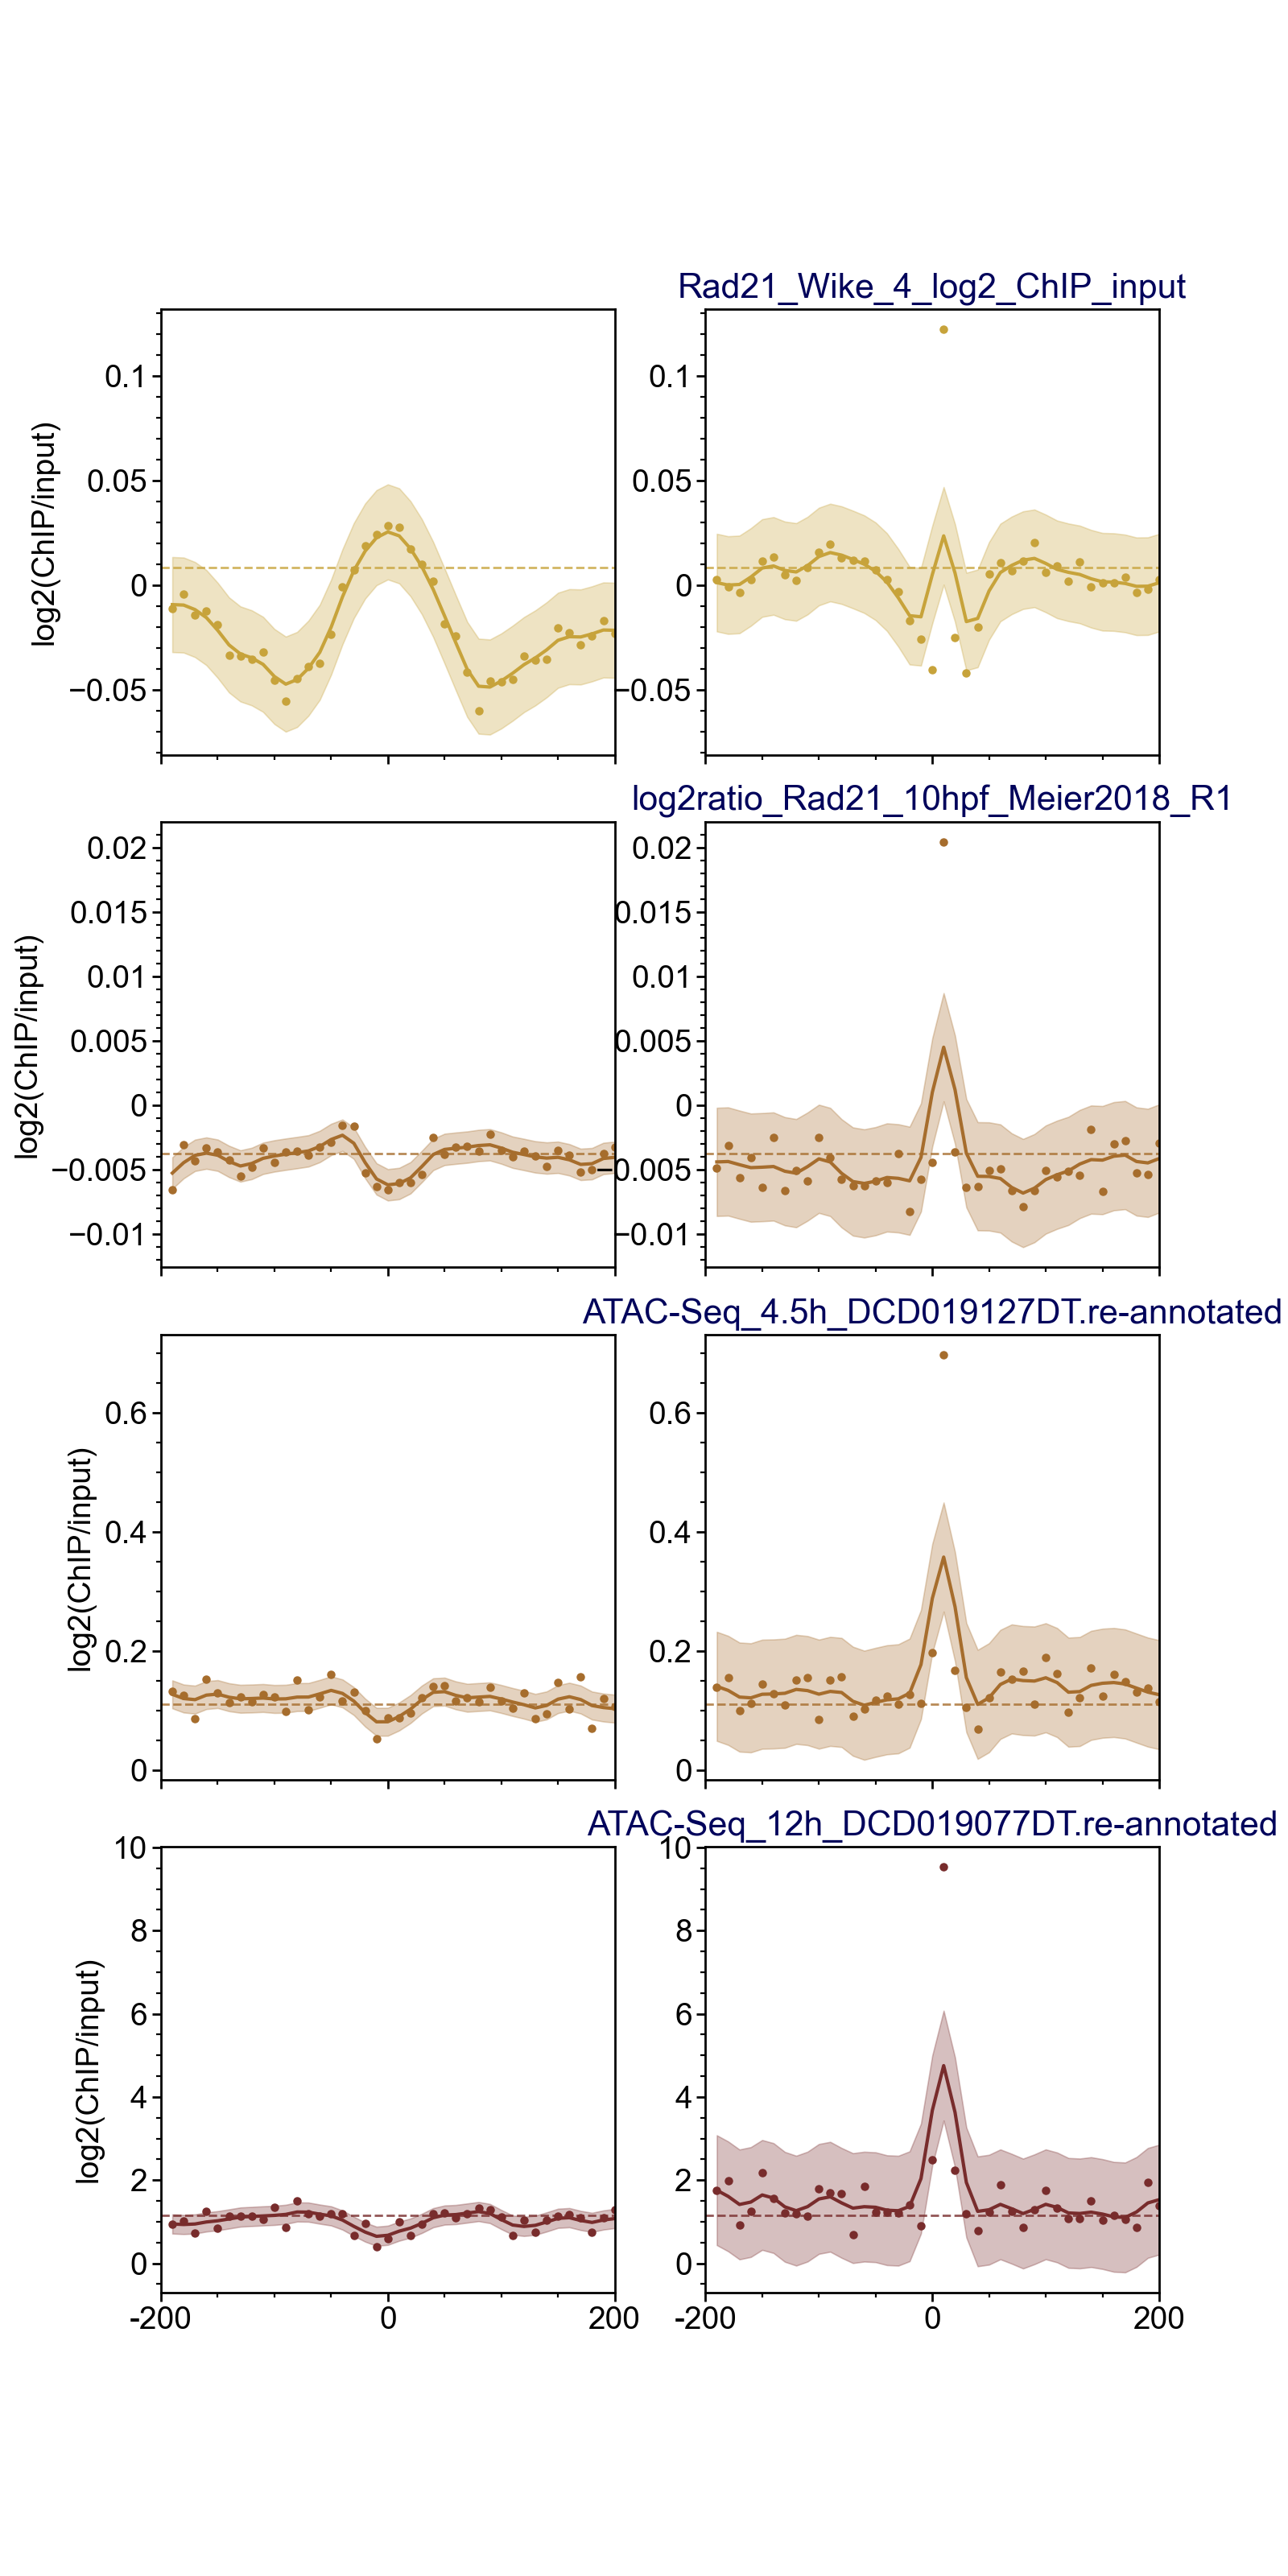

In [30]:
n_tracks_total = 4
n_conditions = 2
figsize = 4
flank = 200_000
ticks_step = 200_000

f, axes = plt.subplots(
    n_tracks_total,
    n_conditions,
    figsize=[figsize * n_conditions, figsize * n_tracks_total],
    sharex=True,
    gridspec_kw={"hspace": 0.15},
)
for i_row in range(n_tracks_total):
    axes[i_row, 0].sharey(*axes[i_row, 1:])
# for i_col in range(1, n_conditions):
#     for i_row in range(n_tracks_total):
#         axes[i_row, i_col].set_yticklabels([])

ylabel = "log2(ChIP/input)"
i_row_offset = 0
tracks = [
    "Rad21_Wike_4_log2_ChIP_input",  # "log2_Rad21-input_Wike2021.10",
    "log2ratio_Rad21_10hpf_Meier2018_R1",
    "ATAC-Seq_4.5h_DCD019127DT.re-annotated",
    "ATAC-Seq_12h_DCD019077DT.re-annotated",
]
colors = [
    color_fountains_dome,
    color_fountains_late,
    color_insulation_early,
    color_insulation_late,
]

for i_row, (track, color) in enumerate(zip(tracks, colors)):
    f_stack = f"{track}.npy"
    f_bg = f"{track}.bg"
    stack = stacks_bins[f_stack]
    bg = bgs_bins[f_bg]["value"].values
    title_stack = f_stack.replace(".npy", "")
    for i_col, (idx, label, _) in enumerate(conds):
        plot_profile(
            stack,
            bg,
            idx,
            ax=axes[i_row + i_row_offset, i_col],
            color=color,
            label=label,
            ylabel=ylabel,
            run_zscore=False,
            flank=flank,
            resolution=binsize,
            ticks_step=ticks_step,
            abline_y=True,
            scatter=True,
        )

for i_row in range(len(tracks)):
    axes[i_row + i_row_offset, 0].set_ylabel(ylabel)
    axes[i_row + i_row_offset, 1].set_title(tracks[i_row])

f.tight_layout()

if do_save:
    prefix = f"{output_folder}/SFig2C.profiles.WT-fount-bound"
    f.savefig(f"{prefix}.pdf")
    f.savefig(f"{prefix}.png")

In [31]:
output_data = []

ylabel = "log2(ChIP/input)"
tracks = [
    "log2_Rad21-input_Wike2021.10",
    "log2ratio_Rad21_10hpf_Meier2018_R1",
    "ATAC-Seq_4.5h_DCD019127DT.re-annotated",
    "ATAC-Seq_12h_DCD019077DT.re-annotated",
]
for i_col, (idx, label, color) in enumerate(conds):
    for i_row, track in enumerate(tracks):
        f_stack = f"{track}.npy"
        f_bg = f"{track}.bg"
        stack = stacks_bins[f_stack]
        bg = bgs_bins[f_bg]["value"].values
        title_stack = f_stack.replace(".npy", "")
        x, y_mean, y_smooth, y_std_smooth, bg_mean = plot_profile(
            stack, bg, idx, run_zscore=False, return_source_data=True
        )
        df_output = pd.DataFrame(
            {
                "x": x * binsize - flank - binsize,
                "y_mean": y_mean,
                "y_smoothed": y_smooth,
                "y_std_smoothed": y_std_smooth,
                "bg": bg_mean,
            }
        ).T
        df_output.loc[:, "track"] = track
        df_output.loc[:, "ylabel"] = ylabel
        df_output.loc[:, "position"] = label

        output_data.append(df_output.copy())
        del df_output

In [32]:
output_data = pd.concat(output_data)

if do_save:
    prefix = f"{output_folder}/SFig2C.profiles.WT-fount-bound"
    output_data.to_csv(f"{prefix}.source.csv", sep="\t")

#### + Replication timing (Fig. 2B)

In [33]:
from lib.read_nonstandard import stacks_bins_1Mb

[23:08:04] lib:INFO: Collecting epigenetic stacks (500 Kb flank)
[23:09:24] lib:INFO: Loaded 224 stacks (500 Kb flank)
[23:09:24] lib:INFO: Collecting epigenetic stacks (1 Mb flank)
[23:11:33] lib:INFO: Loaded 180 stacks (1 Mb flank)
[23:11:33] lib:INFO: Loading 500 Kb snippet stacks for WT


In [34]:
df_boundaries = bins.loc[bins_boundaries_robust, :]

In [35]:
conds = [
    (0, "512", df_fount_differential.index, "fountains 5.3 hpf", color_fountains_dome),
    (0, "512", df_boundaries.index, "boundaries 11 hpf", color_insulation_late),
    (1, "dome", df_fount_differential.index, "fountains 5.3 hpf", color_fountains_dome),
    (1, "dome", df_boundaries.index, "boundaries 11 hpf", color_insulation_late),
    (2, "bud", df_fount_differential.index, "fountains 5.3 hpf", color_fountains_dome),
    (2, "bud", df_boundaries.index, "boundaries 11 hpf", color_insulation_late),
    (3, "28", df_fount_differential.index, "fountains 5.3 hpf", color_fountains_dome),
    (3, "28", df_boundaries.index, "boundaries 11 hpf", color_insulation_late),
]

In [36]:
flank = 1_000_000
ticks_sep = 1_000_000

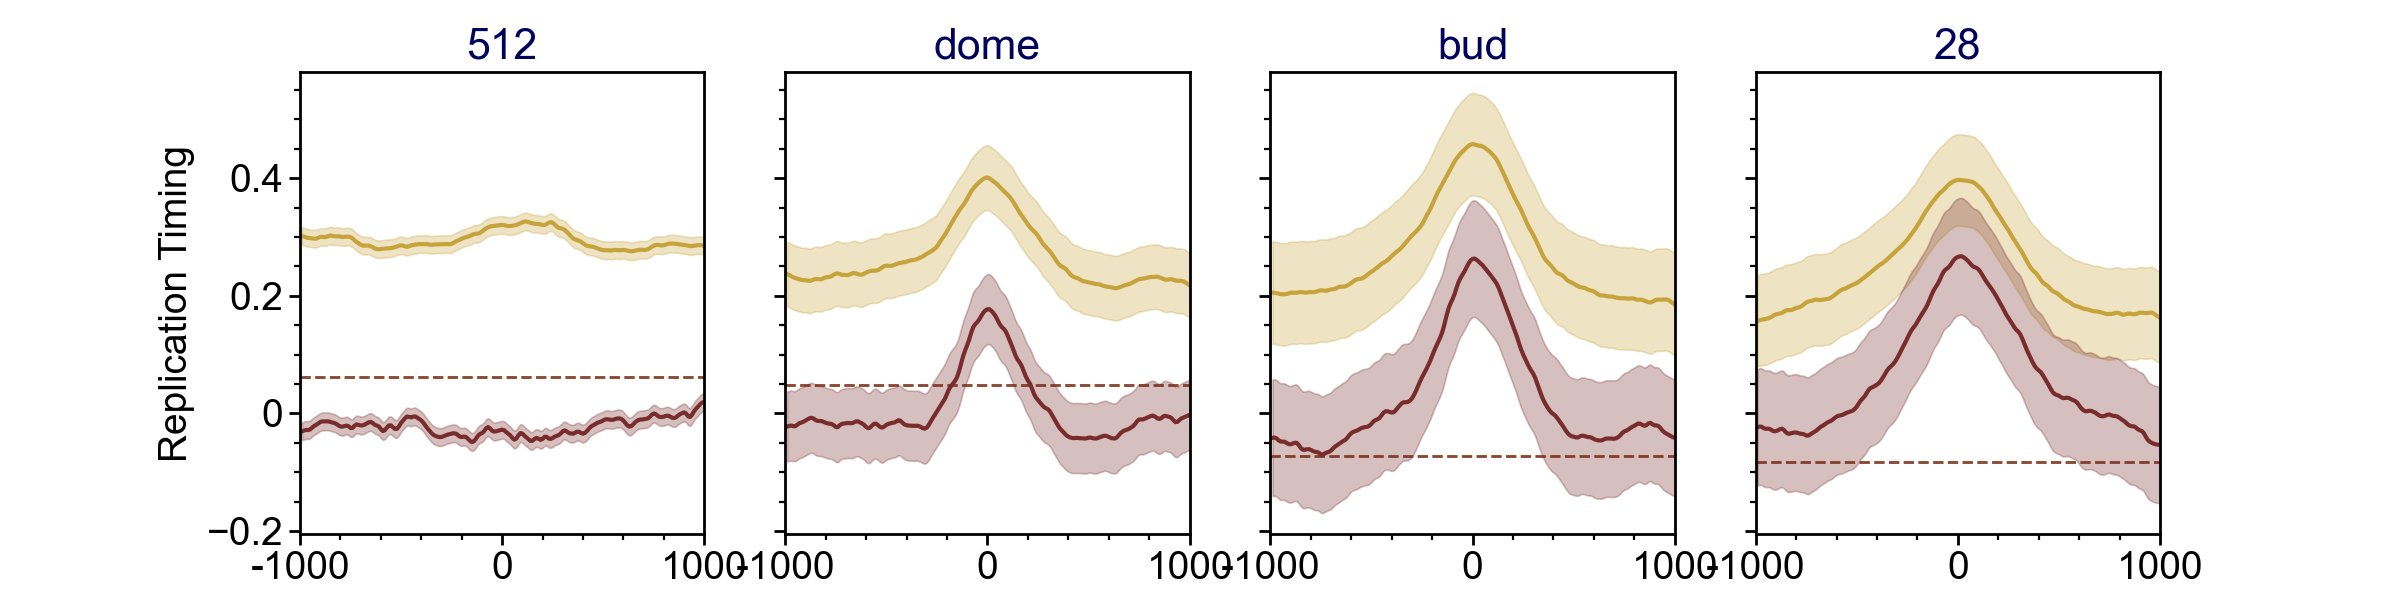

In [37]:
f, axes = plt.subplots(1, 4, figsize=[12, 3], sharey=True)

ylabel = "Replication Timing"

for i, track, idx, label, color in conds:

    f_stack = f"{track}.npy"
    f_bg = f"{track}.bg"
    stack = stacks_bins_1Mb[f_stack]
    bg = bgs_bins[f_bg]["value"].values
    title_stack = f_stack.replace(".npy", "")

    plot_profile(
        stack,
        bg,
        idx,
        ax=axes[i],
        color=color,
        label=label,
        ylabel=ylabel,
        run_zscore=False,
        flank=flank,
        resolution=binsize,
        ticks_step=ticks_sep,
        abline_y=True,
        abline_x=False,
        scatter=False,
        suptitle=title_stack,
    )

axes[0].set_ylabel(ylabel)

if do_save:
    prefix = f"{output_folder}/Fig2B.profiles-RT.WT-fount"
    f.savefig(f"{prefix}.pdf")
    f.savefig(f"{prefix}.png")

In [38]:
output_data = []

ylabel = "Replication Timing"

for i, track, idx, label, color in conds:
    f_stack = f"{track}.npy"
    f_bg = f"{track}.bg"
    stack = stacks_bins_1Mb[f_stack]
    bg = bgs_bins[f_bg]["value"].values
    title_stack = f_stack.replace(".npy", "")
    x, y_mean, y_smooth, y_std_smooth, bg_mean = plot_profile(
        stack, bg, idx, run_zscore=False, return_source_data=True
    )
    df_output = pd.DataFrame(
        {
            "x": x * binsize - flank - binsize,
            "y_mean": y_mean,
            "y_smoothed": y_smooth,
            "y_std_smoothed": y_std_smooth,
            "bg": bg_mean,
        }
    ).T
    df_output.loc[:, "track"] = track
    df_output.loc[:, "label"] = label
    df_output.loc[:, "ylabel"] = ylabel

    output_data.append(df_output.copy())
    del df_output

In [39]:
output_data = pd.concat(output_data)

if do_save:
    prefix = f"{output_folder}/Fig2B.profiles-RT.WT-fount"
    output_data.to_csv(f"{prefix}.source.csv", sep="\t")

In [40]:
section_flush()

✅ Section cleaned


### + Fountains vs initiation zones (Fig. 2F, 500 Kb)

In [41]:
section_start()

✅ Section started


In [42]:
from lib.read_nonstandard import stacks_bins_500Kb

In [43]:
conds = [
    (df_fount_differential.index.astype(int), "Fountains", "#C7A33B"),
    (
        bins_IZ.dropna(subset="start_IZ").index.astype(int),
        "Initiation Zones",
        "#2a2b77",
    ),
]

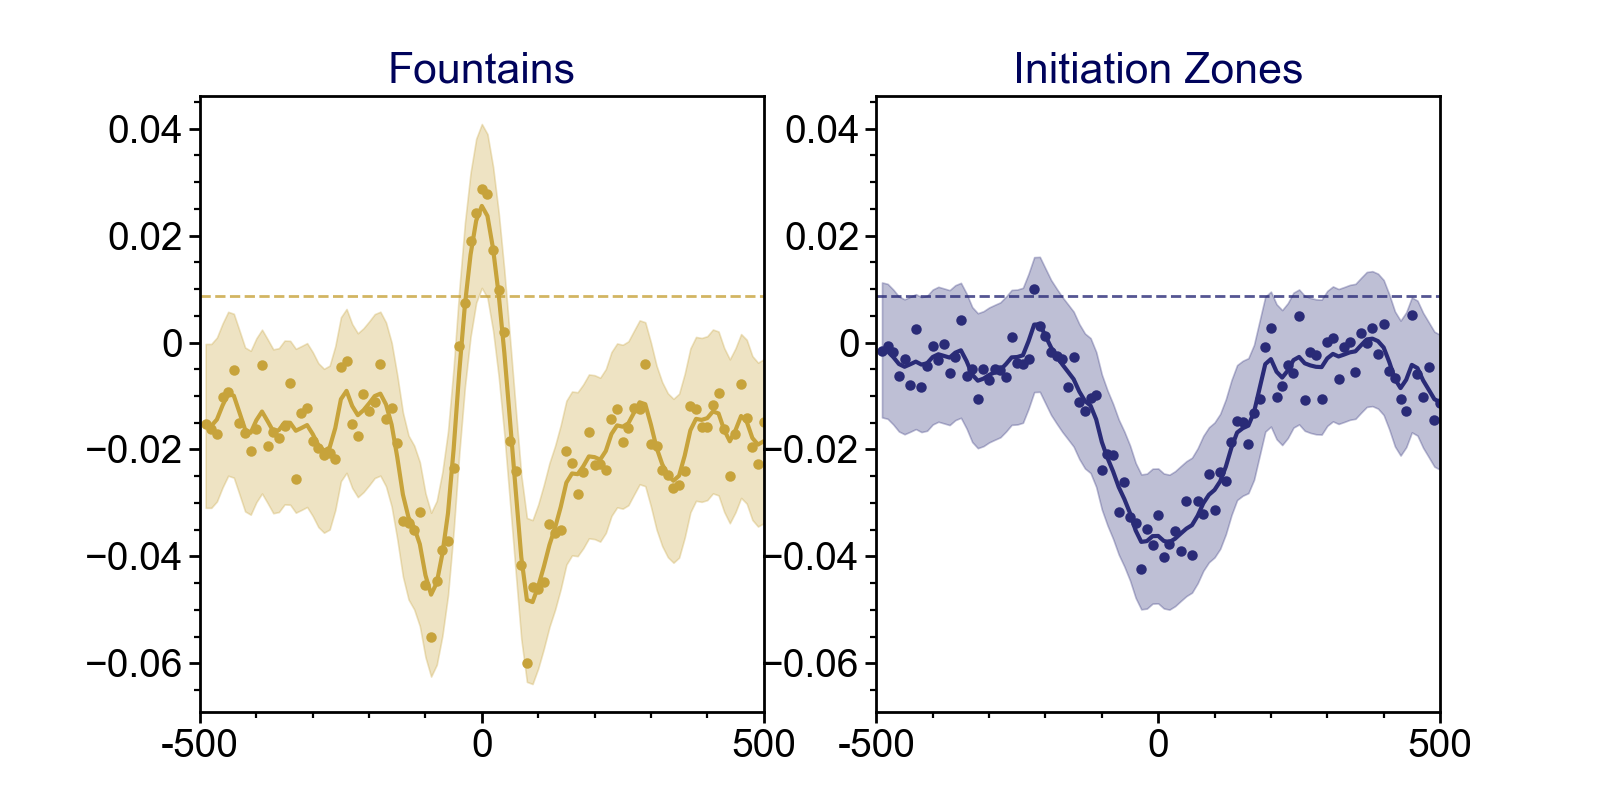

In [44]:
n_tracks_total = 1
n_conditions = 2
figsize = 4

flank = 500_000
ticks_sep = 500_000

f, axes = plt.subplots(
    n_tracks_total,
    n_conditions,
    figsize=[figsize * n_conditions, figsize * n_tracks_total],
    sharex=True,
    gridspec_kw={"hspace": 0.15},
)

axes = axes[..., np.newaxis].T

# Control figure alignment and ticks:
for i_row in range(n_tracks_total):
    axes[i_row, 0].sharey(*axes[i_row, 1:])


ylabel = "log2(ChIP/input)"
i_row_offset = 0
tracks = ["Rad21_Wike_4_log2_ChIP_input"]

for i_row, track in enumerate(tracks):
    f_stack = f"{track}.npy"
    f_bg = f"{track}.bg"
    stack = stacks_bins_500Kb[f_stack]
    bg = bgs_bins[f_bg]["value"].values
    title_stack = f_stack.replace(".npy", "")
    for i_col, (idx, label, color) in enumerate(conds):
        plot_profile(
            stack,
            bg,
            idx,
            ax=axes[i_row + i_row_offset, i_col],
            color=color,
            label=label,
            ylabel=ylabel,
            run_zscore=False,
            flank=flank,
            resolution=binsize,
            ticks_step=ticks_sep,
            abline_y=True,
        )
        axes[i_row + i_row_offset, i_col].set_title(label)

f.tight_layout()

if do_save:
    prefix = f"{output_folder}/Fig2F.profiles.fount-IZ"
    f.savefig(f"{prefix}.pdf")
    f.savefig(f"{prefix}.png")

In [45]:
output_data = []

tracks = ["Rad21_Wike_4_log2_ChIP_input"]
for i_row, track in enumerate(tracks):
    f_stack = f"{track}.npy"
    f_bg = f"{track}.bg"
    stack = stacks_bins_500Kb[f_stack]
    bg = bgs_bins[f_bg]["value"].values
    title_stack = f_stack.replace(".npy", "")

    for i_col, (idx, label, color) in enumerate(conds):
        x, y_mean, y_smooth, y_std_smooth, bg_mean = plot_profile(
            stack, bg, idx, run_zscore=False, return_source_data=True
        )
        df_output = pd.DataFrame(
            {
                "x": x * binsize - flank - binsize,
                "y_mean": y_mean,
                "y_smoothed": y_smooth,
                "y_std_smoothed": y_std_smooth,
                "bg": bg_mean,
            }
        ).T
        df_output.loc[:, "track"] = label
        df_output.loc[:, "ylabel"] = track

        output_data.append(df_output.copy())
        del df_output

output_data = pd.concat(output_data)

In [46]:
if do_save:
    prefix = f"{output_folder}/Fig2F.profiles.fount-IZ"
    output_data.to_csv(f"{prefix}.source.csv", sep="\t")

In [47]:
section_flush()

✅ Section cleaned


#### + Hi-C pileups

In [48]:
section_start()

✅ Section started


In [49]:
from lib.read_nonstandard import dct_stacks_hic_500Kb

In [50]:
flank = 500_000

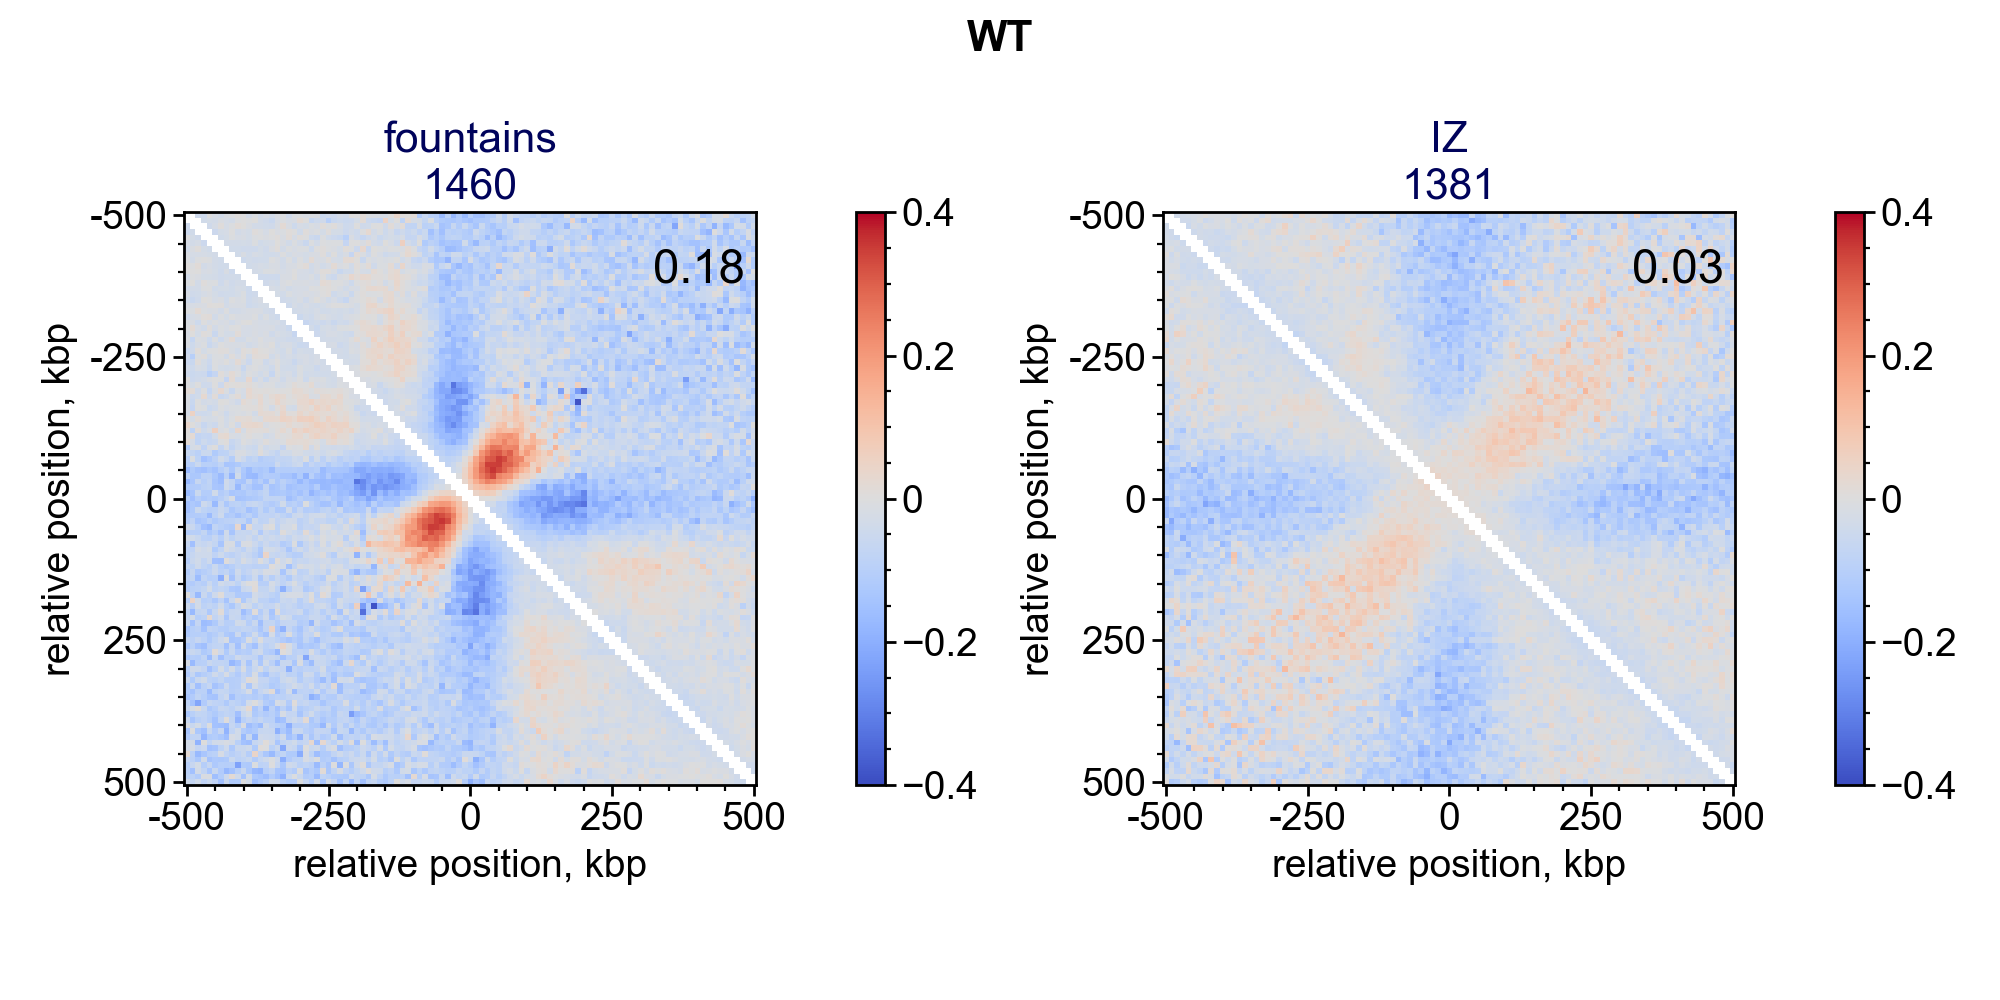

In [51]:
# Save the Hi-C pileups

titles = ["fountains", "IZ"]
idxs = [
    df_fount_differential.index.astype(int),
    bins_IZ.dropna(subset="start_IZ").index.astype(int),
]

for source_fountains in ["WT"]:

    stacks_list = dct_stacks_hic_500Kb[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=2,
        flank=flank,
        resolution=binsize,
        figsize=(10, 5),
        vmin=-0.4,
        vmax=0.4,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df_fountain_strength[source_fountains],
        add_counts=True,
        func=np.nanmean,
    )

    f.suptitle(source_fountains)

if do_save:
    prefix = f"{output_folder}/Fig2F-top.pileups.WT-fount-IZ"
    f.savefig(f"{prefix}.pdf")
    f.savefig(f"{prefix}.png")

In [52]:
# Save the Hi-C pileups
titles = ["fountains", "IZ"]
idxs = [
    df_fount_differential.index,
    bins_IZ.index,
]

for source_fountains in ["WT"]:

    stacks_list = dct_stacks_hic_500Kb[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        avscore=df_fountain_strength[source_fountains],
        return_source_data=True,
    );

In [53]:
if do_save:
    # Fountains:
    df_tmp = pd.DataFrame(data_pileups[0][2])
    df_tmp.insert(loc=0, column="fountain score", value=data_pileups[0][1])
    df_tmp.insert(loc=0, column="label", value=data_pileups[0][0])

    prefix = f"{output_folder}/Fig2F-top.pileups.WT-fount"
    df_tmp.to_csv(f"{prefix}.source.tsv", sep="\t")

    # Boundaries:
    df_tmp = pd.DataFrame(data_pileups[1][2])
    df_tmp.insert(loc=0, column="fountain score", value=data_pileups[1][1])
    df_tmp.insert(loc=0, column="label", value=data_pileups[1][0])

    prefix = f"{output_folder}/Fig2F-top.pileups.WT-IZ"
    df_tmp.to_csv(f"{prefix}.source.tsv", sep="\t")

In [54]:
section_flush()

✅ Section cleaned


### + Enhancers grouped by Rad21 enrichment (Fig. 2E)

In this section, we'll use a custom scheme for loading of ChIP-Seq data and pileups. 
Mostly we need it b/c enhancers have more fine resolution than our usual 10 Kb, and can have variable size. 
We also want to probe 10 Kb-vicinity of the enhancers and not the usual window sizes that we defined for stackups. 

In [55]:
section_start()

✅ Section started


In [9]:
from lib.read_data_basic import df_colors_all

In [10]:
cols = df_colors_all.columns[:4]

In [11]:
df_enhancers = bioframe.sort_bedframe(
    bioframe.overlap(
        df_colors_all.query('stage=="Dome" and state=="5_EnhA1"'),
        bioframe.make_viewframe(chromsizes),
        return_index=True,
    )
    .dropna(subset="index_", axis=0)
    .drop_duplicates("index")
    .sort_index()
    .loc[:, cols]
).reset_index(drop=True)

# 5422 active enhancers (dome regulatory elements Enhancer A1, data from 41) were sorted to four groups by descending Rad-21 ChIP-seq signal (data from 4).

In [12]:
len(df_enhancers)

5426

In [13]:
file_rad21 = "/home/agalicina/DANIO/HIC/WD_2021_paper/13_epigenetics/data/bigwigs/Rad21_Daria/Rad21_Wike_4_log2_ChIP_input.bigwig"

In [14]:
# Read Rad21 signal:
enrichment_enh_rad21 = bbi.stackup(
    file_rad21,
    chroms=df_enhancers["chrom"],
    starts=df_enhancers["start"],
    ends=df_enhancers["end"],
    bins=1,
    missing=0,
)
df_enhancers.loc[:, "Rad21"] = enrichment_enh_rad21

# Assign groups:
df_enhancers.loc[:, "Rad21_group"] = pd.qcut(
    df_enhancers.loc[:, "Rad21"],
    [0, 0.25, 0.5, 0.75, 1],
    labels=["bottom", "mid-bottom", "mid-top", "top"],
)

In [15]:
df_enhancers.loc[:, "mid"] = (
    df_enhancers.loc[:, "start"] + df_enhancers.loc[:, "end"]
) // 2
df_enhancers.loc[:, "mid_end"] = (
    df_enhancers.loc[:, "start"] + df_enhancers.loc[:, "end"]
) // 2 + 1

In [16]:
df_enhancers.loc[:, ["start_5K", "end_5K"]] = (
    bioframe.expand(df_enhancers, pad=5000, cols=["chrom", "mid", "mid_end"])
    .loc[:, ["mid", "mid_end"]]
    .values.astype(int)
)
df_enhancers[["start_5K", "end_5K"]] = df_enhancers[
    ["start_5K", "end_5K"]
].values.astype(int)

In [17]:
stack_enh_rad21 = bbi.stackup(
    file_rad21,
    chroms=df_enhancers["chrom"],
    starts=df_enhancers["start_5K"],
    ends=df_enhancers["end_5K"],
    bins=1001,
)

In [18]:
toplot = [
    (df_enhancers.query("Rad21_group=='bottom'").index, "bottom 25%", "#3e54a4"),
    (df_enhancers.query("Rad21_group=='mid-bottom'").index, "25-50%", "#3e54a4"),
    (df_enhancers.query("Rad21_group=='mid-top'").index, "50-75%", "#3e54a4"),
    (df_enhancers.query("Rad21_group=='top'").index, "top 25%", "#3e54a4"),
]

In [19]:
flank = 5_000
ticks_step = 5_000

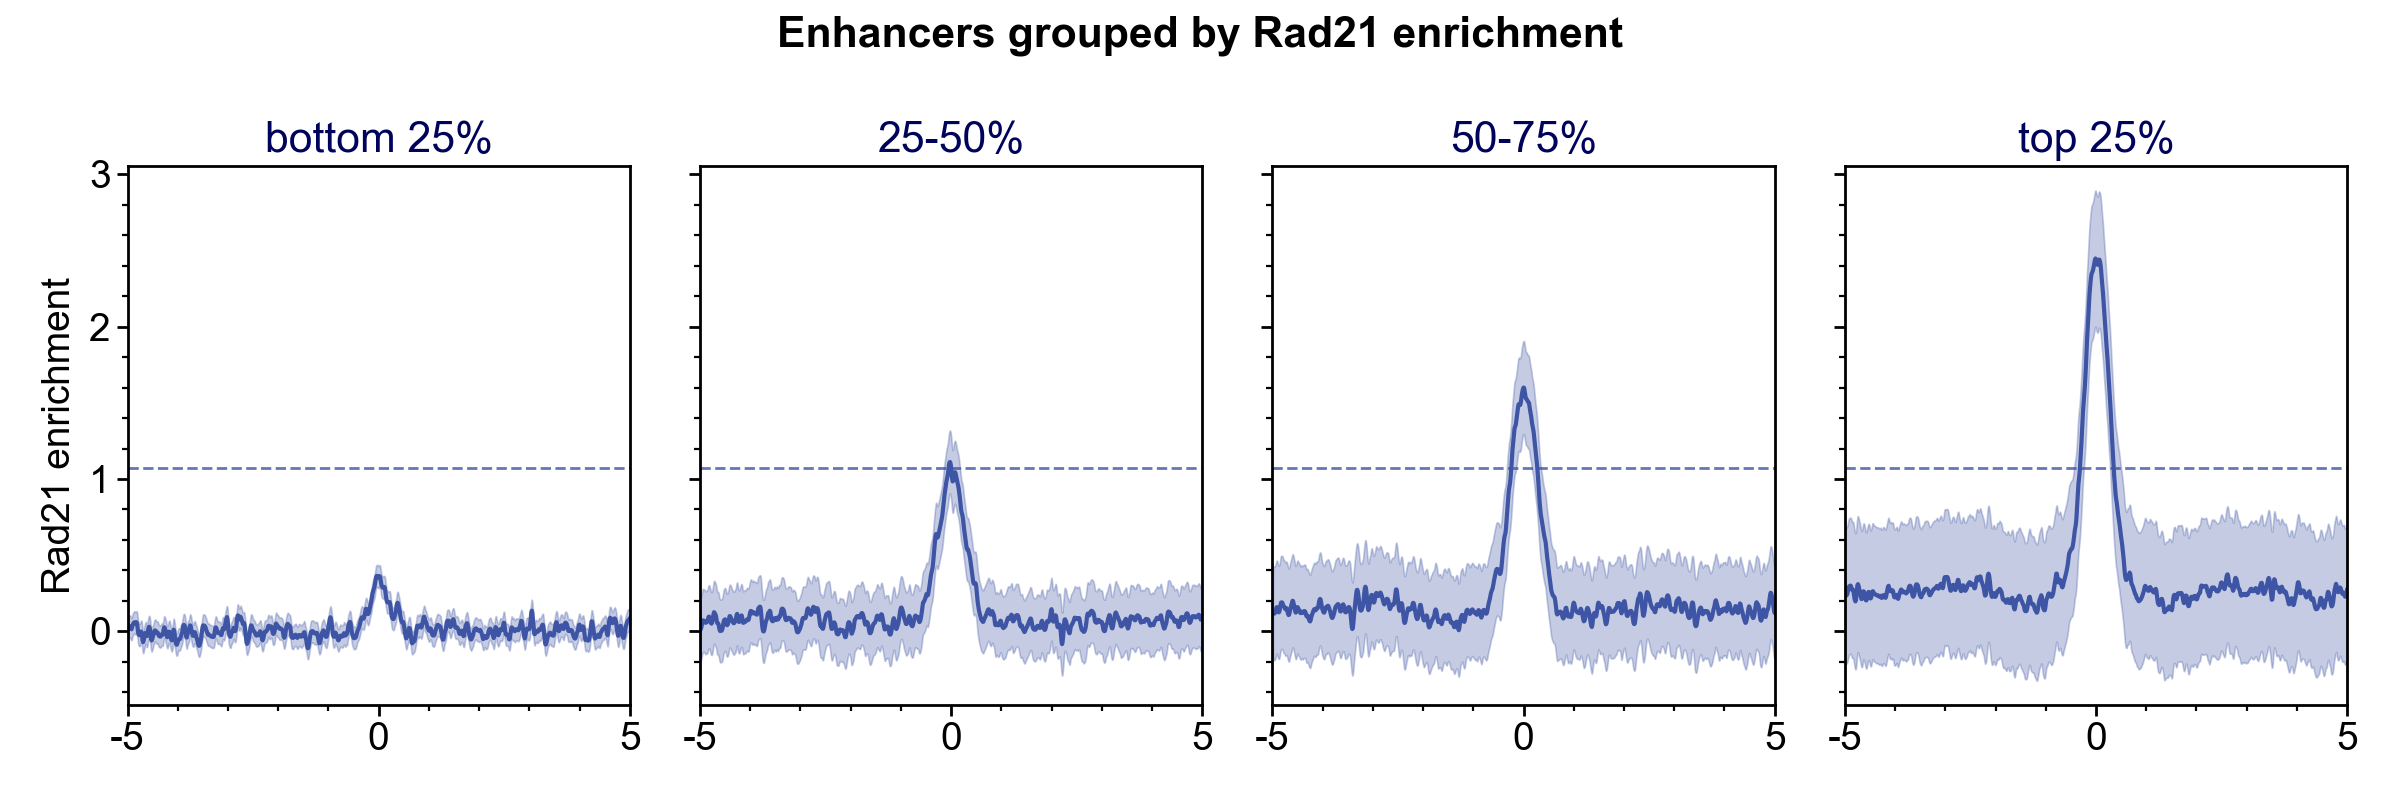

In [20]:
f, axes = plt.subplots(1, 4, figsize=[12, 4], sharey=True)

ylabel = "Rad21 enrichment"
title_stack = "Enhancers grouped by Rad21 enrichment"

for i, (idx, label, color) in enumerate(toplot):

    plot_profile(
        stack_enh_rad21,
        df_enhancers["Rad21"].values,
        idx,
        ax=axes[i],
        color=color,
        label=label,
        ylabel=ylabel,
        run_zscore=False,
        flank=flank,
        resolution=10,
        ticks_step=ticks_step,
        abline_y=True,
        abline_x=False,
        scatter=False,
        run_smooth=True,
    )
    axes[i].set_title(label)

axes[0].set_ylabel(ylabel)

f.suptitle(title_stack)

f.tight_layout()

# Save the figure
if do_save:
    prefix = f"{output_folder}/Fig2E.profiles.enh-Rad21"
    f.savefig(f"{prefix}.pdf")
    f.savefig(f"{prefix}.png")

In [21]:
output_data = []

ylabel = "Rad21 enrichment"
title_stack = "Enhancers grouped by Rad21 enrichment"

for i, (idx, label, color) in enumerate(toplot):
    x, y_mean, y_smooth, y_std_smooth, bg_mean = plot_profile(
        stack_enh_rad21,
        df_enhancers["Rad21"].values,
        idx,
        run_zscore=False,
        return_source_data=True,
    )
    df_output = pd.DataFrame(
        {
            "x": x * binsize - flank - binsize,
            "y_mean": y_mean,
            "y_smoothed": y_smooth,
            "y_std_smoothed": y_std_smooth,
            "bg": bg_mean,
        }
    ).T
    df_output.loc[:, "track"] = label
    df_output.loc[:, "ylabel"] = ylabel

    output_data.append(df_output.copy())
    del df_output

output_data = pd.concat(output_data)

In [22]:
if do_save:
    prefix = f"{output_folder}/Fig2E.profiles.enh-Rad21"
    output_data.to_csv(f"{prefix}.source.csv", sep="\t")

#### + Hi-C pileups

In [23]:
df_enhancers.loc[:, "bin_id"] = bioframe.overlap(
    df_enhancers,
    bins,
    return_index=True,
    return_input=False,
    suffixes=["", "_bins"],
    cols1=["chrom", "mid", "mid_end"],
).loc[:, "index_bins"]

In [24]:
# from lib.read_nonstandard import dct_stacks_hic_500Kb

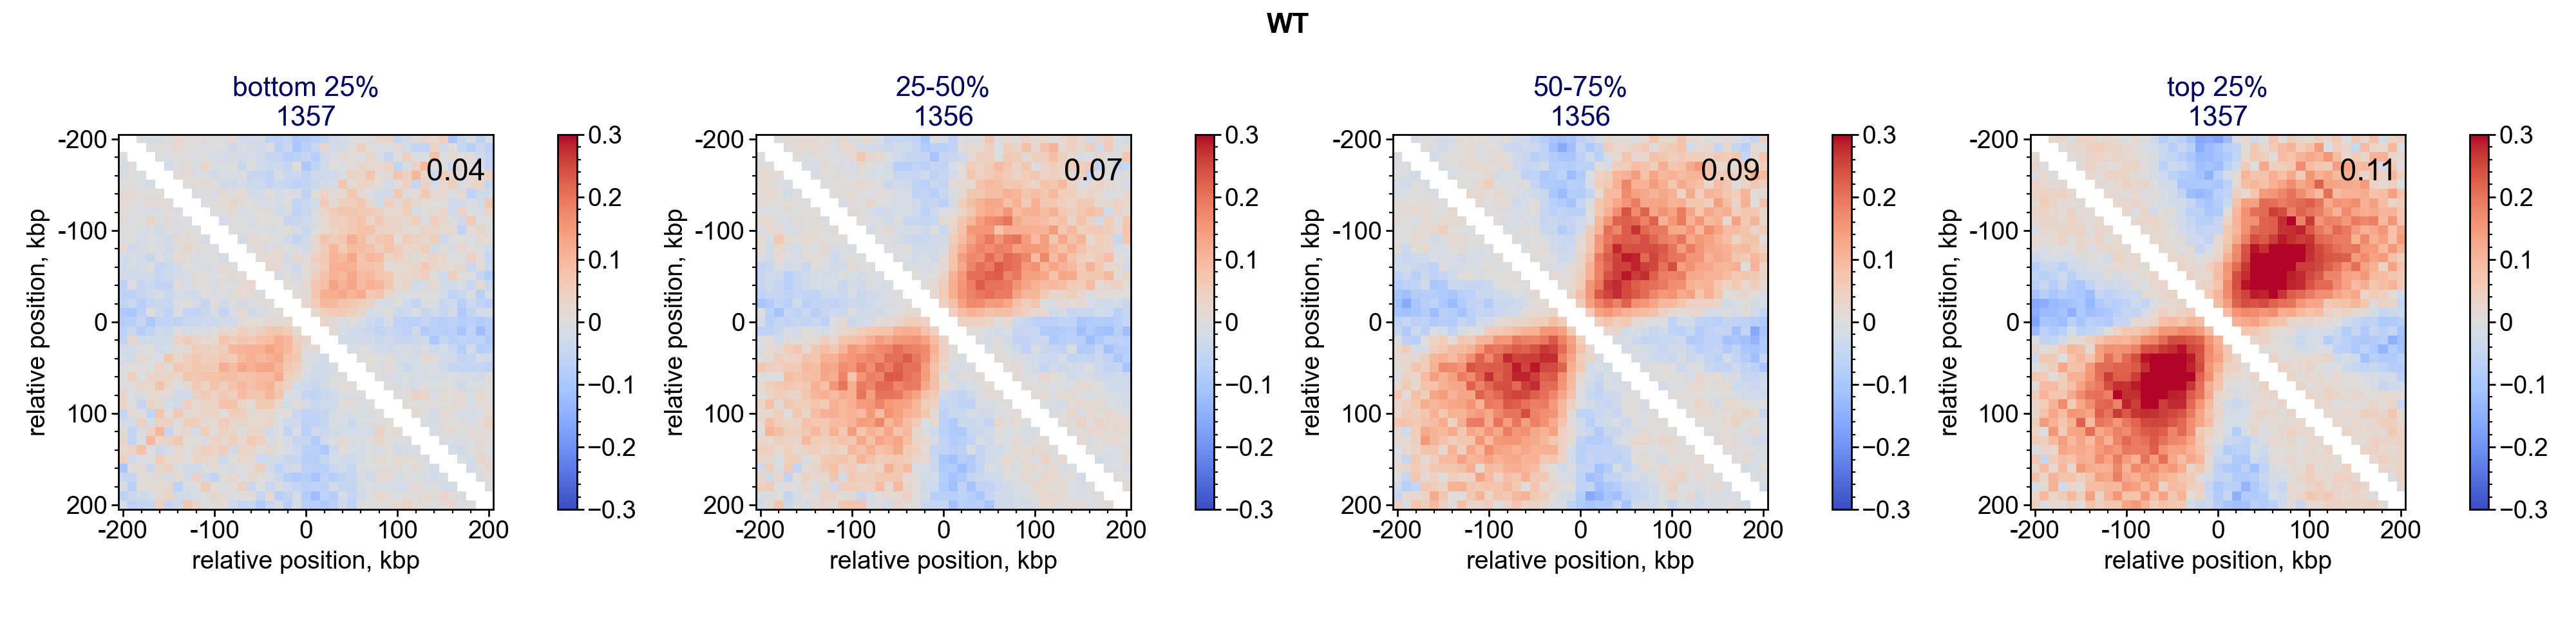

In [29]:
# Save the Hi-C pileups
flank = 200_000
titles = ["bottom 25%", "25-50%", "50-75%", "top 25%"]
idxs = [
    df_enhancers.query("Rad21_group=='bottom'").loc[:, "bin_id"].values,
    df_enhancers.query("Rad21_group=='mid-bottom'").loc[:, "bin_id"].values,
    df_enhancers.query("Rad21_group=='mid-top'").loc[:, "bin_id"].values,
    df_enhancers.query("Rad21_group=='top'").loc[:, "bin_id"].values,
]

for source_fountains in ["WT"]:

    stacks_list = dct_stacks_hic[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=4,
        flank=flank,
        resolution=binsize,
        figsize=(20, 5),
        vmin=-0.3,
        vmax=0.3,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df_fountain_strength[source_fountains],
        add_counts=True,
        func=np.nanmean,
    )

    f.suptitle(source_fountains)

if do_save:
    prefix = f"{output_folder}/Fig2E-top.pileups.enh-Rad21"
    f.savefig(f"{prefix}.pdf")
    f.savefig(f"{prefix}.png")

In [30]:
# Save the Hi-C pileups
flank = 200_000
titles = ["bottom 25%", "25-50%", "50-75%", "top 25%"]
idxs = [
    df_enhancers.query("Rad21_group=='bottom'").loc[:, "bin_id"].values,
    df_enhancers.query("Rad21_group=='mid-bottom'").loc[:, "bin_id"].values,
    df_enhancers.query("Rad21_group=='mid-top'").loc[:, "bin_id"].values,
    df_enhancers.query("Rad21_group=='top'").loc[:, "bin_id"].values,
]

for source_fountains in ["WT"]:

    stacks_list = dct_stacks_hic[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=2,
        flank=flank,
        resolution=binsize,
        figsize=(10, 5),
        vmin=-0.5,
        vmax=0.5,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df_fountain_strength[source_fountains],
        add_counts=True,
        return_source_data=True,
    );

In [31]:
if do_save:
    output = []
    for i in range(len(data_pileups)):
        df_tmp = pd.DataFrame(data_pileups[i][2])
        df_tmp.insert(loc=0, column="fountain score", value=data_pileups[i][1])
        df_tmp.insert(loc=0, column="label", value=data_pileups[i][0])
        output.append(df_tmp.copy())

    output = pd.concat(output, axis=0)
    prefix = f"{output_folder}/Fig2E-top.pileups.enh-Rad21"
    output.to_csv(f"{prefix}.source.tsv", sep="\t")

In [33]:
section_flush()

### + Comparison of fountains and TAD centers (SFig. 11-12)

In [34]:
section_start()

✅ Section started


In [58]:
def set_xticks(pile, resolution, ax, empty=False):
    l = len(pile)
    ticks = np.arange(0, l + 1, 10)

    if empty:
        ticklabels = ["" for t in ticks - l // 2]
    else:
        ticklabels = [f"{t}Kb" for t in ticks - l // 2]

    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)


def set_yticks(pile, resolution, ax, empty=False):
    l = len(pile)
    ticks = np.arange(0, l + 1, 10)

    if empty:
        ticklabels = ["" for t in ticks - l // 2]
    else:
        ticklabels = [f"{t}Kb" for t in ticks - l // 2]

    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)

#### Averaging fountains (n=10)

In [178]:
source_fountains = "WT"
n_samples_show = 10

idx_selected = (
    df_fountains.loc[:, "SIM"].sort_values().dropna().tail(n_samples_show).index.values
)
n_fountains = len(idx_selected)

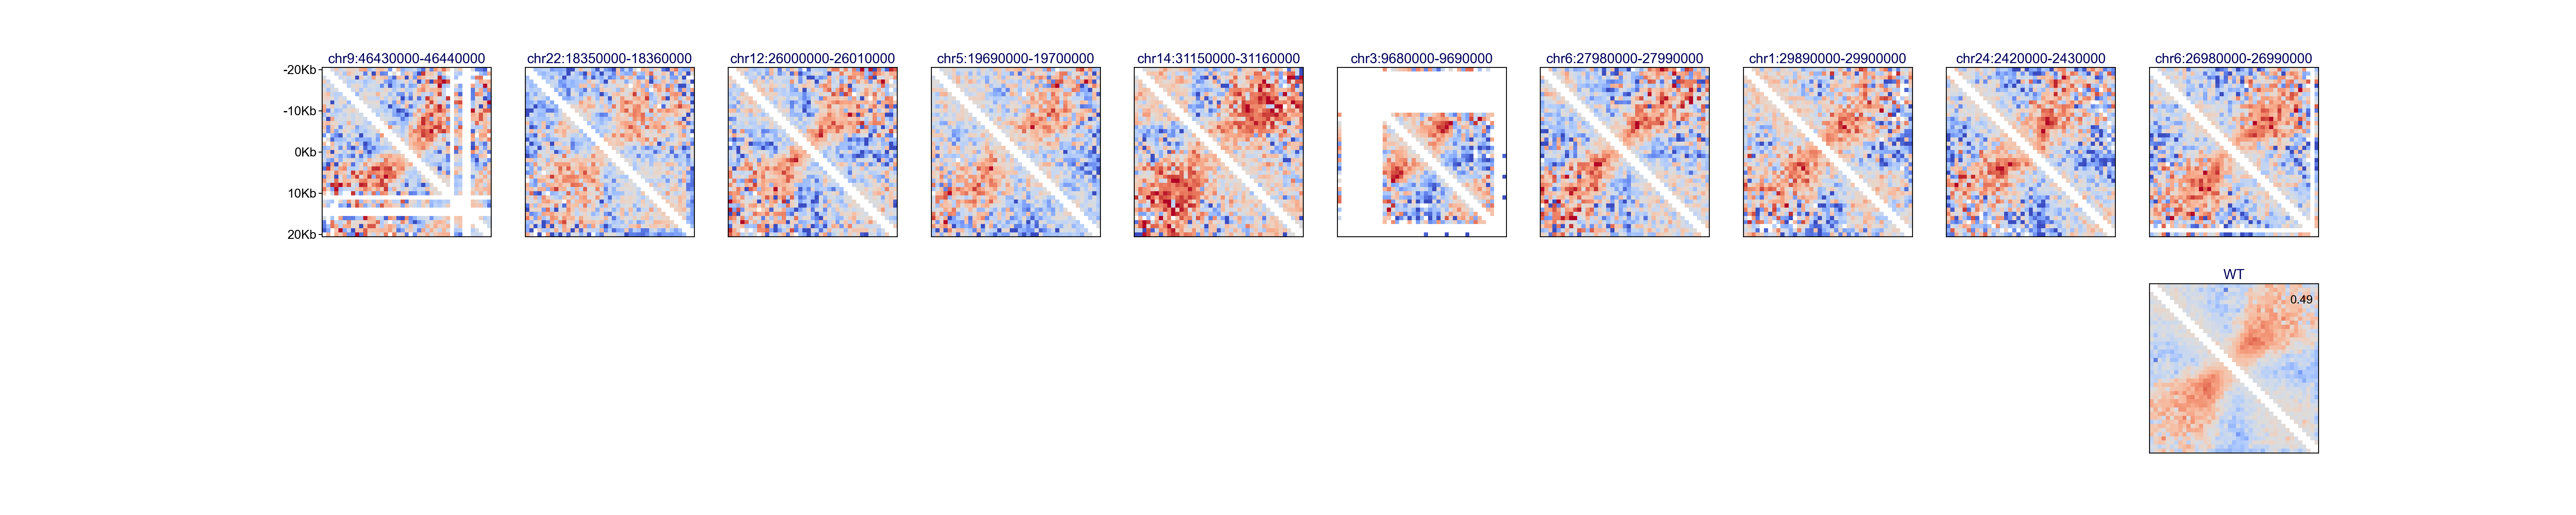

In [160]:
nrows = len(idx_selected) // 10 + 1
ncols = 10

fig, axes = plt.subplots(nrows, ncols, figsize=[4 * ncols, 4 * nrows])
axes_flat = axes.flatten()

for i, idx in enumerate(idx_selected):

    ax = axes_flat[i]

    mtx = dct_stacks_hic[source_fountains][idx, :, :]
    mtx = fontanka.reflect(mtx)

    img = ax.matshow(
        np.log2(mtx), vmin=-1.75, vmax=1.75, cmap="coolwarm", interpolation=None
    )
    ax.xaxis.tick_bottom()
    if i % 10 > 0:
        ax.yaxis.set_visible(False)

    ax.xaxis.set_visible(False)

    ax.minorticks_off()

    reg = bins.loc[idx, ["chrom", "start", "end"]]
    ax.set_title(f"{reg.chrom}:{reg.start}-{reg.end}")

    set_yticks(mtx, binsize, ax)
    set_xticks(mtx, binsize, ax)


ax = axes_flat[-1]

mtx = np.nanmean(dct_stacks_hic[source_fountains][idx_selected, :, :], axis=0)
mtx = fontanka.reflect(mtx)

img = ax.matshow(
    np.log2(mtx), vmin=-1.75, vmax=1.75, cmap="coolwarm", interpolation=None
)
ax.xaxis.tick_bottom()
if i > 0:
    ax.yaxis.set_visible(False)

ax.xaxis.set_visible(False)

ax.minorticks_off()
ax.set_title(source_fountains)

score = np.nanmean(df_fountain_strength.loc[idx_selected, source_fountains])
ax.text(
    0.90,
    0.90,
    f"{score:.2f}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=13,
)

set_yticks(mtx, binsize, ax)
set_xticks(mtx, binsize, ax)

# Remove unused blocks:
used_indices = set(range(n_fountains)) | {len(axes_flat) - 1}  # fountains + mean panel
for j, ax in enumerate(axes_flat):
    if j not in used_indices:
        ax.set_visible(False)  # or ax.axis("off") if you prefer

if do_save:
    prefix = f"{output_folder}/Fig11c-d"
    fig.savefig(f"{prefix}.pdf")
    fig.savefig(f"{prefix}.png")

In [179]:
if do_save:
    prefix = f"{output_folder}/Fig11c.source"
    bins.loc[idx_selected].to_csv(f"{prefix}.csv")

#### Averaging fountains (n=100)

In [180]:
source_fountains = "WT"
n_samples_show = 100

idx_selected = (
    df_fountains.loc[:, "SIM"].sort_values().dropna().tail(n_samples_show).index.values
)
n_fountains = len(idx_selected)

In [165]:
nrows = len(idx_selected) // 10 + 1
ncols = 10

fig, axes = plt.subplots(nrows, ncols, figsize=[4 * ncols, 4 * nrows])
axes_flat = axes.flatten()

for i, idx in enumerate(idx_selected):

    ax = axes_flat[i]

    mtx = dct_stacks_hic[source_fountains][idx, :, :]
    mtx = fontanka.reflect(mtx)

    img = ax.matshow(
        np.log2(mtx), vmin=-1.75, vmax=1.75, cmap="coolwarm", interpolation=None
    )
    ax.xaxis.tick_bottom()
    if i % 10 > 0:
        ax.yaxis.set_visible(False)

    ax.xaxis.set_visible(False)

    ax.minorticks_off()

    reg = bins.loc[idx, ["chrom", "start", "end"]]
    ax.set_title(f"{reg.chrom}:{reg.start}-{reg.end}")

    set_yticks(mtx, binsize, ax)
    set_xticks(mtx, binsize, ax)


ax = axes_flat[-1]

mtx = np.nanmean(dct_stacks_hic[source_fountains][idx_selected, :, :], axis=0)
mtx = fontanka.reflect(mtx)

img = ax.matshow(
    np.log2(mtx), vmin=-1.75, vmax=1.75, cmap="coolwarm", interpolation=None
)
ax.xaxis.tick_bottom()
if i > 0:
    ax.yaxis.set_visible(False)

ax.xaxis.set_visible(False)

ax.minorticks_off()
ax.set_title(source_fountains)

score = np.nanmean(df_fountain_strength.loc[idx_selected, source_fountains])
ax.text(
    0.90,
    0.90,
    f"{score:.2f}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=13,
)

set_yticks(mtx, binsize, ax)
set_xticks(mtx, binsize, ax)

# Remove unused blocks:
used_indices = set(range(n_fountains)) | {len(axes_flat) - 1}  # fountains + mean panel
for j, ax in enumerate(axes_flat):
    if j not in used_indices:
        ax.set_visible(False)  # or ax.axis("off") if you prefer

# Save:
if do_save:
    prefix = f"{output_folder}/Fig11a-b"
    fig.savefig(f"{prefix}.pdf")
    fig.savefig(f"{prefix}.png")

In [181]:
if do_save:
    prefix = f"{output_folder}/Fig11a.source"
    bins.loc[idx_selected].to_csv(f"{prefix}.csv")

#### Get average center of the TAD

In [182]:
df_boundaries = pd.read_csv(
    "/home/agalicina/DANIO/HIC/WD_2021_paper/13_epigenetics/data/boundaries/danio-2022/data/boundaries_200Kbp_all/Wild-Type_11.danrer11-reduced.mapq_30.1000.csv"
)
df_boundaries.columns = ["start", "end", "bs_threshold", "window", "chrom", "IS", "BS"]
df_boundaries = (
    bioframe.overlap(df_boundaries, df_clean_bins, how="left", return_index=True)
    .dropna(subset=["index_"])
    .drop(["index", "index_"], axis=1)
)

In [183]:
df_nonboundaries = bioframe.overlap(df_clean_bins, df_boundaries, return_index=True)
df_nonboundaries = df_nonboundaries.loc[pd.isna(df_nonboundaries.start_), :]

In [184]:
df_centers = pd.merge(
    df_boundaries,
    df_boundaries.shift(-1),
    left_index=True,
    right_index=True,
    suffixes=("_left", "_right"),
)  # .query('chrom_left==chrom_right')
df_centers = df_centers[df_centers["chrom_left"] == df_centers["chrom_right"]]

df_centers = df_centers[
    ["chrom_left", "start_left", "end_left", "start_right", "end_right"]
]
df_centers.loc[:, "chrom"] = df_centers["chrom_left"]
df_centers.loc[:, "start"] = (
    (df_centers["end_left"] + df_centers["start_left"]) // 2
) - binsize // 2
df_centers.loc[:, "end"] = df_centers.loc[:, "start"] + binsize

In [185]:
df_centers = (
    bioframe.overlap(df_centers, df_clean_bins, how="left", return_index=True)
    .dropna(subset=["index_"])
    .drop(["index", "index_"], axis=1)
)

In [186]:
df_centers = (
    bioframe.overlap(df_clean_bins, df_centers, how="left", return_index=True)
    .dropna(subset=["index_"])
    .drop(["index", "index_"], axis=1)
)

#### Averaging centers of TADs (n=10)

In [187]:
source_fountains = "Wild-Type_11"
n_samples_show = 10

idx_nonboundaries = df_centers.index.values  # df_nonboundaries.index.values
drop = (
    [50176, 22125, 2104, 44499, 24513, 58376]
    + [
        16854,
        66824,
        10929,
        71508,
        84282,
        60859,
        2217,
        30743,
        12267,
        68447,
        25300,
        12267,
        3492,
        36680,
        25138,
        12403,
    ]
    + [34922, 22964, 16170, 15497, 62898, 30261]
)

idx_nonboundaries = np.setdiff1d(idx_nonboundaries, drop)

idx_selected = (
    df_fountain_strength.loc[idx_nonboundaries, source_fountains]
    .sort_values()
    .dropna()
    .tail(n_samples_show)
    .index.values
)

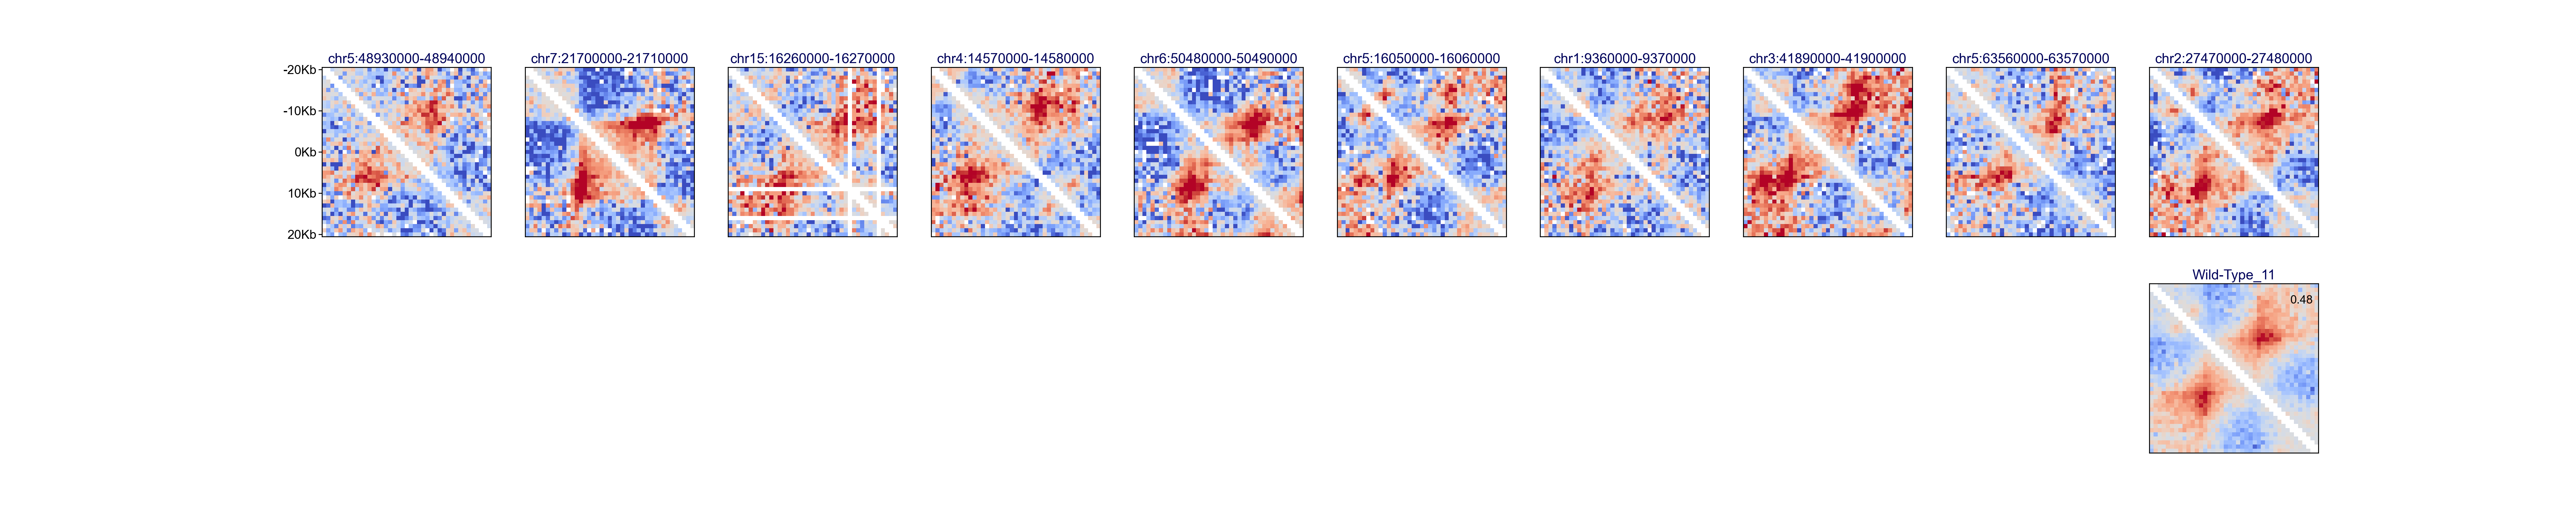

In [173]:
nrows = len(idx_selected) // 10 + 1
ncols = 10

fig, axes = plt.subplots(nrows, ncols, figsize=[4 * ncols, 4 * nrows])
axes_flat = axes.flatten()

for i, idx in enumerate(idx_selected):

    ax = axes_flat[i]

    mtx = dct_stacks_hic[source_fountains][idx, :, :]
    mtx = fontanka.reflect(mtx)

    img = ax.matshow(
        np.log2(mtx), vmin=-1.75, vmax=1.75, cmap="coolwarm", interpolation=None
    )
    ax.xaxis.tick_bottom()
    if i % 10 > 0:
        ax.yaxis.set_visible(False)

    ax.xaxis.set_visible(False)

    ax.minorticks_off()

    reg = bins.loc[idx, ["chrom", "start", "end"]]
    ax.set_title(f"{reg.chrom}:{reg.start}-{reg.end}")

    set_yticks(mtx, binsize, ax)
    set_xticks(mtx, binsize, ax)


ax = axes_flat[-1]

mtx = np.nanmean(dct_stacks_hic[source_fountains][idx_selected, :, :], axis=0)
mtx = fontanka.reflect(mtx)

img = ax.matshow(
    np.log2(mtx), vmin=-1.75, vmax=1.75, cmap="coolwarm", interpolation=None
)
ax.xaxis.tick_bottom()
if i > 0:
    ax.yaxis.set_visible(False)

ax.xaxis.set_visible(False)

ax.minorticks_off()
ax.set_title(source_fountains)

score = np.nanmean(df_fountain_strength.loc[idx_selected, source_fountains])
ax.text(
    0.90,
    0.90,
    f"{score:.2f}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=13,
)

set_yticks(mtx, binsize, ax)
set_xticks(mtx, binsize, ax)

# Remove unused blocks:
used_indices = set(range(n_samples_show)) | {
    len(axes_flat) - 1
}  # fountains + mean panel
for j, ax in enumerate(axes_flat):
    if j not in used_indices:
        ax.set_visible(False)  # or ax.axis("off") if you prefer

if do_save:
    prefix = f"{output_folder}/Fig12c-d"
    fig.savefig(f"{prefix}.pdf")
    fig.savefig(f"{prefix}.png")

In [188]:
if do_save:
    prefix = f"{output_folder}/Fig12c.source"
    bins.loc[idx_selected].to_csv(f"{prefix}.csv")

#### Averaging centers of TADs (n=100)

In [189]:
source_fountains = "Wild-Type_11"
n_samples_show = 100

idx_nonboundaries = df_centers.index.values
drop = (
    [50176, 22125, 2104, 44499, 24513, 58376]
    + [
        16854,
        66824,
        10929,
        71508,
        84282,
        60859,
        2217,
        30743,
        12267,
        68447,
        25300,
        12267,
        3492,
        36680,
        25138,
        12403,
    ]
    + [34922, 22964, 16170, 15497, 62898, 30261]
)

idx_nonboundaries = np.setdiff1d(idx_nonboundaries, drop)

idx_selected = (
    df_fountain_strength.loc[idx_nonboundaries, source_fountains]
    .sort_values()
    .dropna()
    .tail(n_samples_show)
    .index.values
)

In [176]:
nrows = len(idx_selected) // 10 + 1
ncols = 10

fig, axes = plt.subplots(nrows, ncols, figsize=[4 * ncols, 4 * nrows])
axes_flat = axes.flatten()

for i, idx in enumerate(idx_selected):

    ax = axes_flat[i]

    mtx = dct_stacks_hic[source_fountains][idx, :, :]
    mtx = fontanka.reflect(mtx)

    img = ax.matshow(
        np.log2(mtx), vmin=-1.75, vmax=1.75, cmap="coolwarm", interpolation=None
    )
    ax.xaxis.tick_bottom()
    if i % 10 > 0:
        ax.yaxis.set_visible(False)

    ax.xaxis.set_visible(False)

    ax.minorticks_off()

    reg = bins.loc[idx, ["chrom", "start", "end"]]
    ax.set_title(f"{reg.chrom}:{reg.start}-{reg.end}")

    set_yticks(mtx, binsize, ax)
    set_xticks(mtx, binsize, ax)


ax = axes_flat[-1]

mtx = np.nanmean(dct_stacks_hic[source_fountains][idx_selected, :, :], axis=0)
mtx = fontanka.reflect(mtx)

img = ax.matshow(
    np.log2(mtx), vmin=-1.75, vmax=1.75, cmap="coolwarm", interpolation=None
)
ax.xaxis.tick_bottom()
if i > 0:
    ax.yaxis.set_visible(False)

ax.xaxis.set_visible(False)

ax.minorticks_off()
ax.set_title(source_fountains)

score = np.nanmean(df_fountain_strength.loc[idx_selected, source_fountains])
ax.text(
    0.90,
    0.90,
    f"{score:.2f}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=13,
)

set_yticks(mtx, binsize, ax)
set_xticks(mtx, binsize, ax)

# Remove unused blocks:
used_indices = set(range(n_samples_show)) | {
    len(axes_flat) - 1
}  # fountains + mean panel
for j, ax in enumerate(axes_flat):
    if j not in used_indices:
        ax.set_visible(False)  # or ax.axis("off") if you prefer

# Save:
if do_save:
    prefix = f"{output_folder}/Fig12a-b"
    fig.savefig(f"{prefix}.pdf")
    fig.savefig(f"{prefix}.png")

In [190]:
if do_save:
    prefix = f"{output_folder}/Fig12a.source"
    bins.loc[idx_selected].to_csv(f"{prefix}.csv")

In [192]:
section_flush()

✅ Section cleaned
